# Ames Housing OLS Regression Project Part 2
#### Alan Kessler, Predict 410 Section 57

This notebook contains the code accompanying the report. The following modules are used in the analysis.

StatsModels is used inplace of scikit-learn for final model creation due to its more robust offering of statistical diagnostics for regression. Scikit-learn is still used to standardize residuals, cluster using k-means, apply feature selection, and apply cross validation. 

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import scipy.stats
from pandas.api.types import is_string_dtype
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict

# Filter out a warning when fitting regression related to a driver
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# To get balance of size correctly
plt.rcParams['figure.dpi'] = 100

Define functions to get consistent plots and statistics. Additionally, some helper functions are included for use in feature selection.

In [2]:
def category_plot(df, var, 
                  ci=True, width=6.5, height=4, 
                  alpha=0.2, legend_loc='upper right'):
    """Plots one-way relationship for categorical data"""
    
    # Create data for plot
    df = df[[var, 'SalePrice']].groupby(var).agg([len, np.mean, np.std])
    df.columns = df.columns.droplevel()
    df.columns = ['count', 'mean', 'std']
    plotdf = df.reset_index()

    # Create figure with size properties
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)

    # Row count axis
    sns.barplot(x=var, y='count', data=plotdf, ax=ax, 
                color=sns.xkcd_rgb["azure"], label='Count')
    y1ticks = ax.get_yticks()
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in y1ticks])
    ax.set(ylabel='Row Count')

    # Point axis 
    ax2 = ax.twinx()
    sns.pointplot(x=var, y='mean', data=plotdf, ax=ax2, color='black')

    # Legend for the first axis
    lines, labels = ax.get_legend_handles_labels()

    # Add confidence intervals if requested
    if ci:
        z = scipy.stats.norm(0, 1).isf(alpha/2)
        plotdf['lowerCI'] = plotdf['mean'] - z*plotdf['std']/np.sqrt(plotdf['count'])
        sns.pointplot(x=var, y='lowerCI', data=plotdf, ax=ax2, color='slategray')
        plotdf['upperCI'] = plotdf['mean'] + z*plotdf['std']/np.sqrt(plotdf['count'])
        sns.pointplot(x=var, y='upperCI', data=plotdf, ax=ax2, color='slategray')
        ax2.legend(handles=lines + ax2.lines[::len(plotdf)+1], 
                   labels = labels + ["Avg SalePrice", str(100*(1-alpha)) + "% CI"], 
                   prop={'size': 9}, loc=legend_loc)
    else:
        ax2.legend(handles=lines + ax2.lines[:], 
                   labels = labels + ["Avg SalePrice"], 
                   prop={'size': 9}, loc=legend_loc)

    # Modify second axis units
    y2ticks = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0f}'.format(x/1000) for x in y2ticks])
    ax2.set(ylabel='SalePrice ($000)')

    plt.show()

def one_hot_encode(df, base): 
    """Get dummies with reference level as most populated
    df - the pandas dataframe to apply dummies to
    base - the pandas dataframe to base reference levels on"""
    
    dum = df.copy()
    str_vars = []
    
    # Generate list of string variables
    for column in dum.columns:
        if is_string_dtype(dum[column]):
            str_vars.extend([column])
        else:
            pass
    
    # Use pandas to get dummies
    dum = pd.get_dummies(dum, drop_first=False)
    
    # Drop the most populated level
    for column in str_vars:
        mode_level = base[column].mode()[0]
        dum.drop([column+"_"+mode_level], axis=1, inplace=True)
    return dum    

def fit_stats_df(d):
    """Formats fit statistics dictionary for display
    d - existing dictionary of fit statistics"""
    
    df = pd.DataFrame.from_dict(d, orient='index').sort_index()
    df.columns = ['R-Squared', 'Adj R-Squared', 'AIC']
    return df.style.format({'R-Squared': '{:,.4f}'.format,
                            'Adj R-Squared': '{:,.4f}'.format, 
                            'AIC': '{:,.2f}'.format})

def lin_reg_sm(df, var_list, target, verbose=True, dummied=False):
    """Fits regression, returns fit, statistics, charts
    df - pandas dataframe to fit moodel on
    var_list - list of variables to include in the model
    target - string containing variable to use as model target
    verbose - Choosing False skips coefficients and graphing
    dummied - Choosing True skips process of creating dummy variables"""
    
    # Fit regression
    y = df[[target]].copy()
    
    if dummied:
        X_sub = one_hot_encode(df.copy(), df.copy())
        X_dum = sm.add_constant(X_sub[var_list])
    else:
        X_sub = df[var_list].copy()
        X_dum = sm.add_constant(one_hot_encode(X_sub, X_sub))
        
    regr = sm.OLS(y.values, X_dum).fit()
    
    # Fit Statistics - list
    stats_list = [regr.rsquared, regr.rsquared_adj, regr.aic]
    
    if verbose:
        # Coefficient table
        tbl_names = ['Term', 'Coefficient', 'Std Error', 't', 'P>|t|']
        terms = sm.OLS(y.values, X_dum).exog_names
        coeffs = regr.params.tolist()
        std_errors = regr.bse.tolist()
        tvalues = regr.tvalues.tolist()
        pvalues = regr.pvalues.tolist()
        coef_tbl = pd.DataFrame({'Term': terms, 
                                 'Coefficient': coeffs,
                                 'Std Error': std_errors,
                                 't': tvalues,
                                 'P>|t|': pvalues})
        coef_tbl.at[0, 'Term'] = "Intercept"
        coef = coef_tbl[tbl_names].set_index(['Term']).style.format({'Coefficient': '{:,.4f}'.format,
                                                                     'Std Error': '{:,.3f}'.format,
                                                                     't': '{:,.3f}'.format, 
                                                                     'P>|t|': '{:,.3f}'.format})
        display(coef)
        
        # Diagnostic plots
        plt.style.use('seaborn-paper')
        plt.rcParams['figure.figsize'] = [6.5, 5]

        # Residual QQ-Plot
        q = plt.figure().add_subplot(2,2,1)
        sm.qqplot(preprocessing.scale(regr.resid), line='45', dist=scipy.stats.norm, ax=q)
        for ax in plt.gcf().axes:
            ax.get_lines()[0].set_markeredgecolor(sns.xkcd_rgb["denim blue"])
            ax.get_lines()[0].set_markeredgewidth(1)
            ax.get_lines()[0].set_markerfacecolor('none')
            ax.get_lines()[1].set_color(sns.xkcd_rgb["black"])
        plt.title('Normal Q-Q')
                    
        # Residual Scatter Plot
        plt.subplot(2,2,2)
        sc = sns.regplot(x=regr.fittedvalues, y=regr.resid, lowess=True, 
                         line_kws={'color': 'black'},
                         scatter_kws={'edgecolors': sns.xkcd_rgb["denim blue"], 
                                      'facecolors': 'None',
                                      'linewidth': 1})
        yticks = sc.get_yticks()
        sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
        xticks = sc.get_xticks()
        sc.set_xticklabels(['{:,.0f}'.format(x/1000) for x in xticks])
        sc.set(ylabel="Residuals ($000)", xlabel="Fitted Values ($000)")
        plt.title('Residuals vs Fitted')
        
        # Scale-Location Plot
        plt.subplot(2,2,3)
        sc = sns.regplot(x=regr.fittedvalues, 
                         y=np.sqrt(np.absolute(preprocessing.scale(regr.resid))), 
                         lowess=True, line_kws={'color': 'black'},
                         scatter_kws={'edgecolors': sns.xkcd_rgb["denim blue"], 
                                      'facecolors': 'None',
                                      'linewidth': 1})
        xticks = sc.get_xticks()
        sc.set_xticklabels(['{:,.0f}'.format(x/1000) for x in xticks])
        sc.set(ylabel="Sqrt of Standardized Residuals", xlabel="Fitted Values ($000)")
        plt.title('Scale-Location')
        
        # Residuals vs. Leverage Plot
        plt.subplot(2,2,4)
        sc = sns.regplot(x=regr.get_influence().cooks_distance[0], 
                         y=preprocessing.scale(regr.resid), 
                         lowess=True, line_kws={'color': 'black'},
                         scatter_kws={'edgecolors': sns.xkcd_rgb["denim blue"], 
                                      'facecolors': 'None',
                                      'linewidth': 1})
        sc.set(ylabel="Standardized Residuals", xlabel="Cook's Distance")
        plt.xticks(rotation=45)
        plt.title('Residuals vs Leverage')
        
        plt.tight_layout()
        plt.show()

    else:
        pass
    
    return stats_list, regr

def rmse_metric(regr, log=True):
    """Return RMSE for a statsmodel ols object"""
    observed = train_process1['SalePrice'].values
    if log:
        expected = np.exp(regr.fittedvalues.values)
    else:
        expected = regr.fittedvalues.values
    n = len(observed)
    rmse = np.sqrt(np.sum((observed - expected)**2) / n)
    return rmse

def metrics(observed, expected, p):
    """Calculates fit statistics 
    observed - array of actual values
    expected - array of fitted values
    p - integer number of terms used"""
    
    SSE = np.sum((observed - expected)**2)
    SST = np.sum((observed - np.mean(observed))**2)
    n = len(expected)
    rsquared = 1 - (SSE/SST)
    rsquared_adj = 1 - (1-rsquared)*(n-1)/(n-p-1)
    rmse = np.mean((observed - expected)**2)**0.5
    return rsquared, rsquared_adj, rmse

def model_stepc(df, y, step, label):
    """Fits a linear model and returns cross validation fit statistics
    df - pandas dataframe to fit model
    y - target pandas series
    step - forwareds selection step number
    label - variables added to the model to print
    """
    ols = linear_model.LinearRegression()
    X = one_hot_encode(df, df)
    regrsk=ols.fit(X.values, y.values)
    rsquared, rsquared_adj, rmse = metrics(train_process2['SalePrice'].values,
                                           cross_val_predict(regrsk, one_hot_encode(train_process2[df.columns], 
                                                                                    train_process2[df.columns]).values, 
                                                             train_process2['SalePrice'].values,
                                                             cv=5), 
                                           len(X.columns))
    output = "Model {}; Var: {}; R-Squared = {:.3f}; Adj R-Squared = {:.3f}; RMSE = {:.3f};".format(step, label, rsquared, rsquared_adj, rmse)
    return output, rmse

## Data

Importing data and restricting to single family homes identical to Assignment 1.

In [3]:
# Load training data
train = pd.read_csv('AMES_TRAIN.csv', index_col=-1)
# Load testing data - index is in different column
test = pd.read_csv('AMES_TEST_SFAM.csv', index_col=0)
# Drop the blank columns corresponding to the target variables
test.drop(['p_saleprice', 'SalePrice'], axis=1, inplace=True)

# Filter out all but single family homes in training to match test
train_sfam = train.copy()[train['BldgType'] == "1Fam"]

## Baseline

Replicate the final model from Assignment 1 as the baseline.

In [4]:
# Drop the maximum sale price as done in assignment 1
train_m0 = train_sfam.drop(train_sfam['SalePrice'].idxmax(), axis=0)

# Create overall quality groupings
def grp_OQ(row):
    if row['OverallQual'] == 1:
        return "grp_02"
    else:
        return "grp_" + str(row['OverallQual']).zfill(2) 

train_m0['OverallQual_grp'] = train_m0.apply(grp_OQ, axis=1)

test_m0 = test.copy()
test_m0['OverallQual_grp'] = test_m0.apply(grp_OQ, axis=1)

# Remove the outliers removed in assignment 1
outliers = train_m0.sort_values(by='TotalBsmtSF', ascending=False).index[:2].tolist()
outliers.extend([train_m0['LotArea'].idxmax()])
train_m0.drop(outliers, axis=0, inplace=True)

# Fit Model 2 from assignment 1
y = train_m0[['SalePrice']]
X_sub = train_m0[['GrLivArea', 'OverallQual_grp']]
X_dum = sm.add_constant(pd.get_dummies(X_sub, drop_first=True))
regr_m0 = sm.OLS(y.values, X_dum.values).fit()
train_m0['Predictions'] = pd.DataFrame(regr_m0.predict(X_dum))
train_m0['Residuals'] = train_m0['SalePrice'] - train_m0['Predictions']

## Neighborhood Accuracy

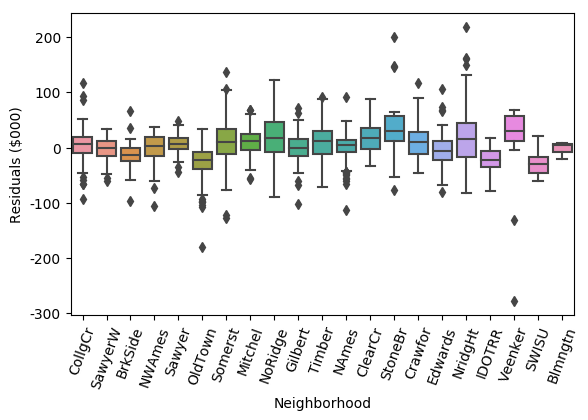

In [5]:
# Box plot of residuals by neighborhood
plt.figure(figsize=(6.5, 4))
ax = sns.boxplot(x='Neighborhood', y='Residuals', data=train_m0)
ticks = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
ax.set(ylabel='Residuals ($000)')
plt.xticks(rotation=70)
plt.show()

Residuals vary considerably by neighborhood. While some neighborhoods such as "Mitchel" and "Sawyer" are predicted well, the model under-predicts for "NridgHt" and over-predicts for "OldTown".

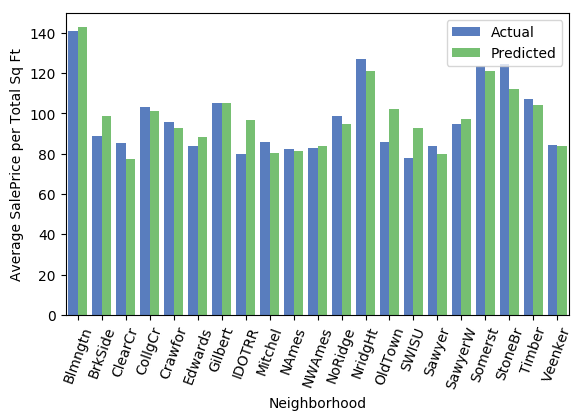

In [6]:
# Create square footage variable
train_m0['totalsqftcalc'] = train_m0['BsmtFinSF1'].fillna(0) + train_m0['BsmtFinSF2'].fillna(0) + train_m0['GrLivArea']

# Create price per square foot variables
train_m0['Act Price per SF'] = train_m0['SalePrice'] / train_m0['totalsqftcalc']
train_m0['Pred Price per SF'] = train_m0['Predictions'] / train_m0['totalsqftcalc']

# Calculate mean price per sqft
sqft = train_m0[['Neighborhood', 
                 'Act Price per SF', 
                 'Pred Price per SF']].groupby('Neighborhood').agg([np.mean])
sqft.columns = sqft.columns.droplevel()
sqft.columns = ['Avg Actual Price per SF', 
                'Avg Predicted Price per SF']

# Plot comparision between actual and predicted
plt.figure(figsize=(6.5, 4))
m = pd.melt(sqft.reset_index(), 
            id_vars=['Neighborhood'], 
            value_vars=['Avg Actual Price per SF', 
                        'Avg Predicted Price per SF'])
m['SalePrice'] = np.where(m['variable'] == "Avg Actual Price per SF", 
                          "Actual", "Predicted")
ax = sns.barplot(x='Neighborhood', y='value', 
                 hue='SalePrice', data=m, palette="muted")
ax.set(ylabel='Average SalePrice per Total Sq Ft')
plt.xticks(rotation=70)
ax.legend(loc='upper right')
plt.setp(ax.get_legend().get_texts(), fontsize='10')
plt.show()

The difference between actual and predicted varies by Neighborhood.

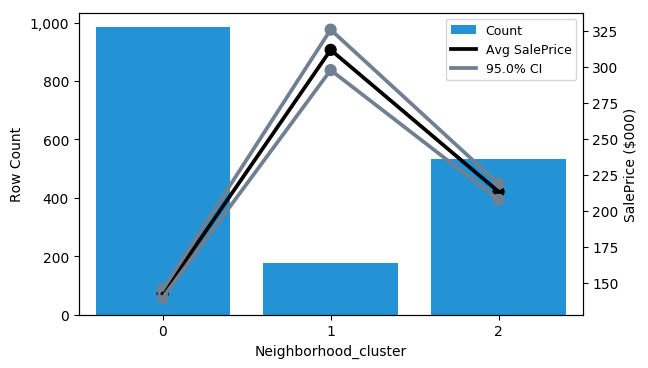

In [7]:
# Cluster neighborhoods into 3 clusters by avg price per sq as a string
kmeans = KMeans(n_clusters=3, random_state=9).fit(sqft[['Avg Actual Price per SF']].values)
sqft['Neighborhood_cluster'] = kmeans.predict(sqft[['Avg Actual Price per SF']].values)

# Drop cluster variable if it already exists in training data
try:
    train_m0.drop(['Neighborhood_cluster'], axis=1, inplace=True)
except:
    pass

# Merge with training data
train_m0 = train_m0.merge(sqft[['Neighborhood_cluster']].reset_index(),
                          on=['Neighborhood'], how='left')

# Convert to string to use as categorical
train_m0['Neighborhood_cluster'] = train_m0['Neighborhood_cluster'].astype(str)

# Plot relationship (cluster numbers will not be in order)
category_plot(train_m0, var = 'Neighborhood_cluster', alpha=0.05)

Using k-means clustering, neighborhoods are grouped into one of three clusters based on average actual sale price per square foot.

## Model 1 - Baseline with Neighborhood Clusters

Neighborhood clusters are added to the model with the most populous group being the base level as a common practice. This is done because the significance of the other groups will be compared to this base group. The output would be harder to understand if the base group itself was rare.

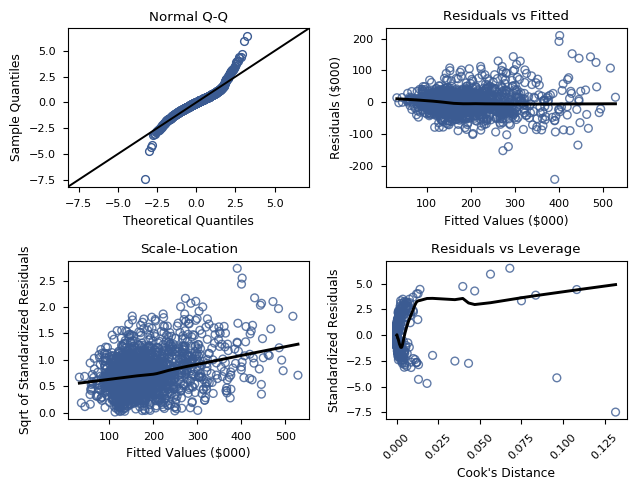

In [8]:
# Display fit statistics for the baseline and model 1
fits = {}
fits['Assignment 1'] = [regr_m0.rsquared, regr_m0.rsquared_adj, regr_m0.aic]
m1_vars = ['GrLivArea', 'OverallQual_grp', 'Neighborhood_cluster']
fits['Model 1'], regr_m1 = lin_reg_sm(train_m0, m1_vars, 'SalePrice')
fit_stats_df(fits)

Normal qq-plot shows that residuals are heavy-tailed. Residuals appear unbiased. Appears that the assumption of equal variances is violated. Several points are very influential in the data. Overall, the fit is an improvement.

## Model 2 - Variables from Provided Code

Incorporate the quality index and total square feet as defined in the code provided in the assignment. Because square footage and quality is included, total square footage above grade and overall quality are dropped to mitigate multicollinearity.

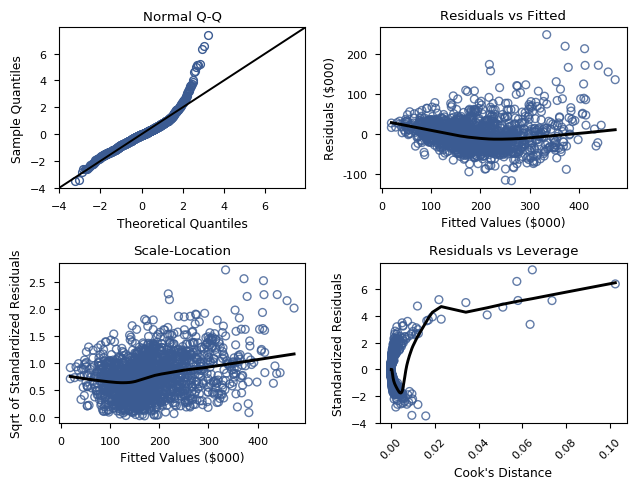

In [9]:
# Add variable from shell code (total square feet already added)
train_m0['qualityindex'] = train_m0['OverallQual'] * train_m0['OverallCond']

# Fit model and compare
m2_vars = ['Neighborhood_cluster', 'qualityindex', 'totalsqftcalc']
fits['Model 2'], regr_m2 = lin_reg_sm(train_m0, m2_vars, 'SalePrice')
fit_stats_df(fits)

Normal qq-plot shows that residuals are heavy-tailed. Residuals appear unbiased. Appears that the assumption of equal variances is violated. Several points are very influential in the data. Overall, the fit is an improvement.

## Additional Feature Creation

Prior to feature creation, separate variables by type: numerical and categorical.

Some of the added variables will involve capping so outlier removal will be more limited. This restricts the ability to compare to models 1 and 2 but this just needs to be kept in mind.

In [10]:
# Columns treated as interval/continuous/discrete/ordinal variables
intVars = ['MiscVal', 'PoolArea', 'ScreenPorch',
           'ThreeSsnPorch', 'EnclosedPorch', 'OpenPorchSF',
           'WoodDeckSF', 'GarageArea', 'LotArea',
           'GrLivArea', 'LowQualFinSF', 'FirstFlrSF',
           'SecondFlrSF', 'TotalBsmtSF', 'BsmtUnfSF',
           'BsmtFinSF2', 'BsmtFinSF1', 'MasVnrArea',
           'LotFrontage', 'YearBuilt', 'YearRemodel', 
           'GarageYrBlt', 'TotRmsAbvGrd', 'SalePrice']

# Columns treated as categorical variables
# Includes ordinal and low cardinality interval/discrete/ordinal
nomVars = np.setdiff1d(train_sfam.columns, intVars).tolist()

Impute missing values

In [11]:
# Variables that should be imputed with blanks
nomVars_toBlank = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtQual', 'GarageCond', 
                   'GarageFinish', 'GarageQual','Fence', 'FireplaceQu', 
                   'GarageType', 'MiscFeature', 'PoolQC']

# Variables that should be imputed with zero
nomVars_toZero = ['BsmtFullBath', 'BsmtHalfBath']

# Process missing variables & correct errors
def process_miss(df):
    adj = df.copy()
    adj.GarageYrBlt.replace({2207:2007}, inplace=True)
    for column in intVars[:-1]:
        if column == 'LotFrontage':
            adj[column].fillna(train_sfam[column].mean(), inplace=True)
        else:
            adj[column].fillna(0, inplace=True)
    for column in nomVars:
        if column in nomVars_toBlank:
            adj[column].fillna("Blank", inplace=True)
        elif column in nomVars_toZero:
            adj[column].fillna(0.0, inplace=True)
        else:
            adj[column].fillna(train_sfam[column].mode()[0], inplace=True)
    return adj

train_miss = process_miss(train_sfam)
test_miss = process_miss(test)

Drop outliers

In [12]:
# Index value of the outliers for sq footage
# Lot area outlier now is just capped
outliers = train_miss.sort_values(by='GrLivArea', ascending=False).index[:2].tolist()
train_miss.drop(outliers, axis=0, inplace=True)

In [13]:
# Create features based on continuous variables
def cont_features(df):
    cf = df.copy()
    # Group outdoor space variable
    cf['OutdoorSF'] = cf['ScreenPorch'] + cf['ThreeSsnPorch'] + cf['EnclosedPorch'] + cf['OpenPorchSF'] + cf['WoodDeckSF']
    # Create indicator for low quality
    cf['LowQualFin_ind'] = np.where(cf['LowQualFinSF'] > 0, 1, 0)
    # Create second floor indicator
    cf['SecondFlr_ind'] = np.where(cf['SecondFlrSF'] > 0, 1, 0)
    # Create finished basement SF
    cf['BsmtFSF'] = cf['TotalBsmtSF'] - cf['BsmtUnfSF']
    # Cap lot area at 14000 matching previous report
    cf['LotArea_cap'] = np.where(cf['LotArea'] >= 20000, 20000, cf['LotArea'])
    # Floor year built at 1950
    cf['YearBuilt_flr'] = np.where(cf['YearBuilt'] < 1950, 1950, cf['YearBuilt'])
    # Use home age instead
    cf['HomeAge_flr'] = cf['YrSold'] - cf['YearBuilt_flr']
    # Drop intermediate feature for year built
    cf.drop(['YearBuilt_flr'], axis=1, inplace=True)
    return cf

train_process1 = cont_features(train_miss)
test_process1 = cont_features(test_miss)

In [14]:
train_process1['SalePrice_log'] = np.log(train_process1['SalePrice'])

# Final list of continous variables
intVars_final = ['OutdoorSF', 'BsmtFSF', 'GarageArea', 'LotArea_cap',
                 'GrLivArea', 'BsmtUnfSF', 'MasVnrArea', 
                 'LotFrontage', 'TotRmsAbvGrd', 'HomeAge_flr',
                 'SalePrice', 'SalePrice_log']

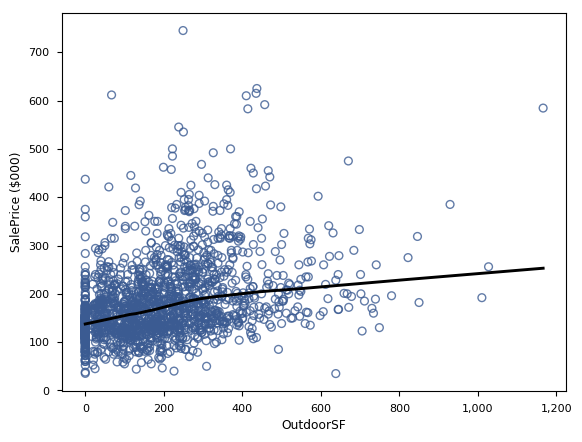

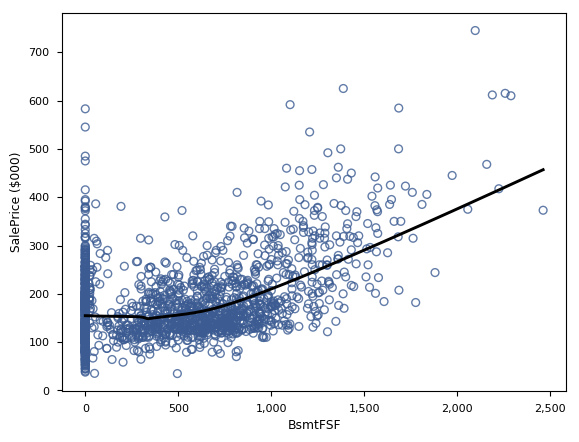

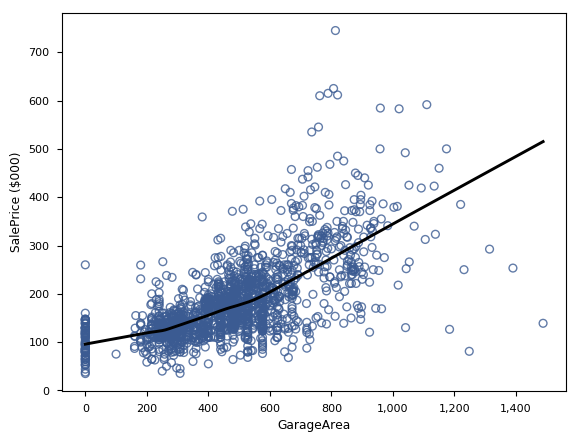

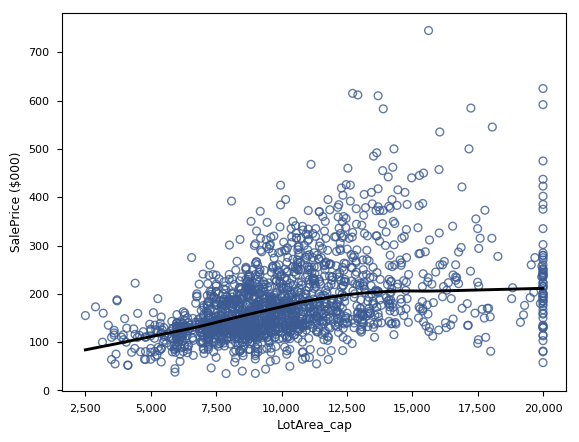

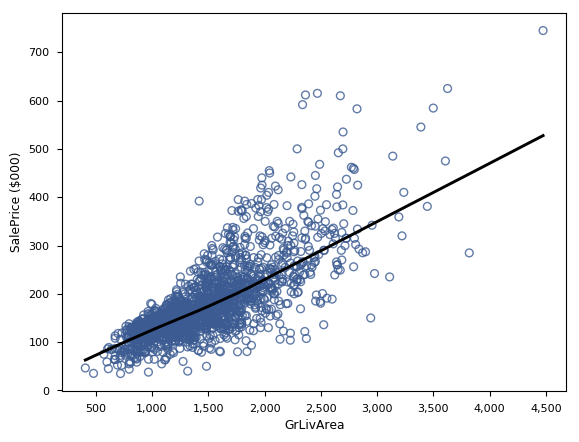

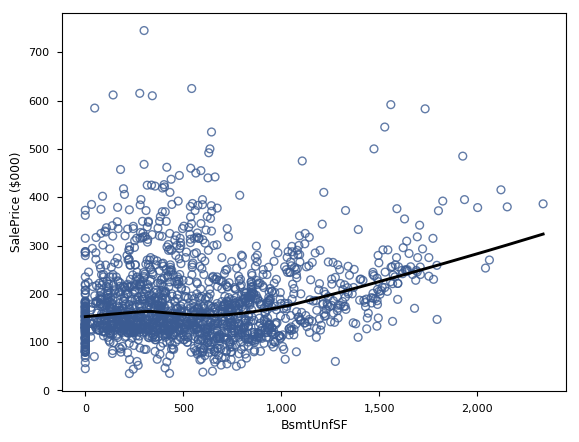

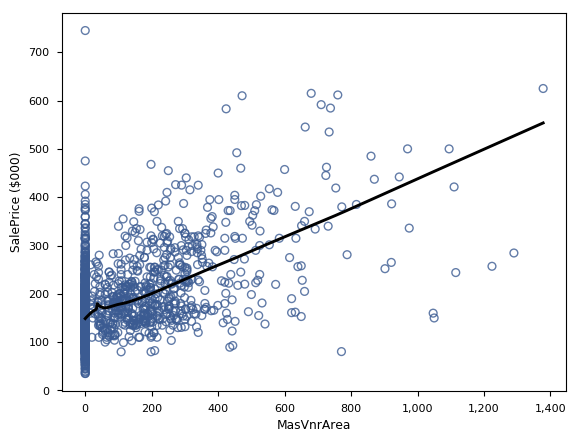

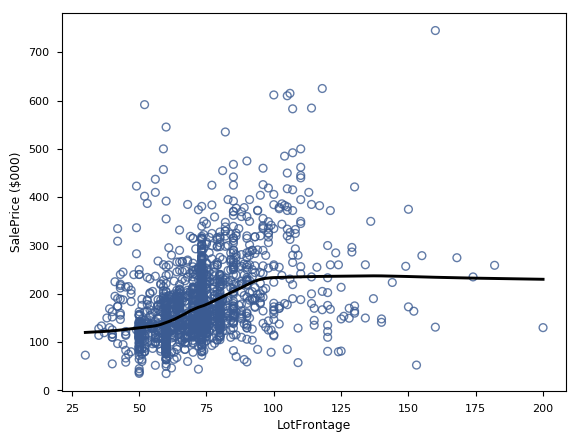

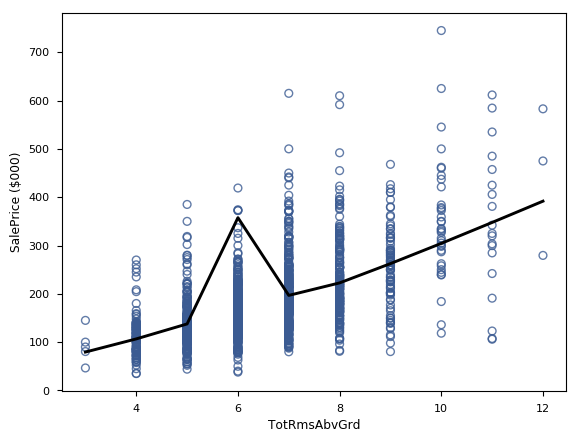

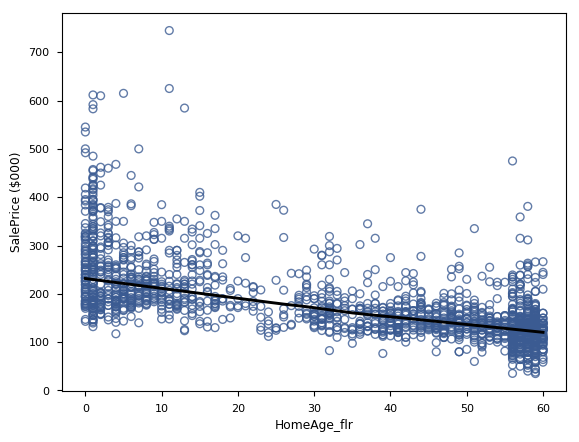

In [15]:
# Plot one way relationships with SalePrice
for var in intVars_final:
    if var in ["SalePrice", "SalePrice_log"]:
        pass
    else:
        sc = sns.regplot(x=var, y="SalePrice", 
                         data=train_process1, lowess=True, 
                         line_kws={'color': 'black'},
                         scatter_kws={'edgecolors': sns.xkcd_rgb["denim blue"], 
                                      'facecolors': 'None',
                                      'linewidth': 1})
        yticks = sc.get_yticks()
        sc.set_yticklabels(['{:,.0f}'.format(x/1000) for x in yticks])
        xticks = sc.get_xticks()
        sc.set_xticklabels(['{:,.0f}'.format(x) for x in xticks])
        sc.set(ylabel="SalePrice ($000)")
        plt.show()

In [16]:
# Add neighborhood clusters to this refreshed set of data
# Drop cluster variable if it already exists in training and testing data
try:
    train_process1.drop(['Neighborhood_cluster'], axis=1, inplace=True)
    test_process1.drop(['Neighborhood_cluster'], axis=1, inplace=True)
except:
    pass

# Merge with training and testing data
train_process1 = train_process1.reset_index().merge(sqft[['Neighborhood_cluster']].reset_index(),
                                      on=['Neighborhood'], how='left')
train_process1.set_index(['index'], inplace=True)
test_process1 = test_process1.reset_index().merge(sqft[['Neighborhood_cluster']].reset_index(),
                                      on=['Neighborhood'], how='left')
test_process1.set_index(['index'], inplace=True)

# Convert to string to use as categorical
train_process1['Neighborhood_cluster'] = train_process1['Neighborhood_cluster'].astype(str)
test_process1['Neighborhood_cluster'] = test_process1['Neighborhood_cluster'].astype(str)

## Model 3 - Additional Continuous Variables

Model 1 terms with additional significant continuous variables. Variables with p-values over 0.05 are excluded.

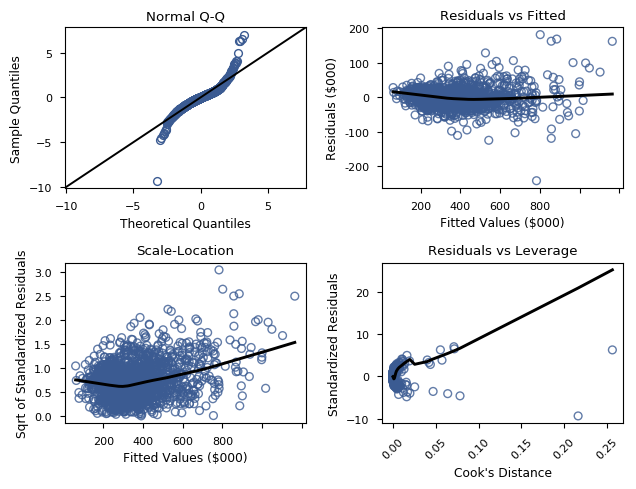

In [17]:
def grp_OQ(row):
    if row['OverallQual'] == 1:
        return "grp_02"
    else:
        return "grp_" + str(row['OverallQual']).zfill(2) 

train_process1['OverallQual_grp'] = train_process1.apply(grp_OQ, axis=1)
test_process1['OverallQual_grp'] = test_process1.apply(grp_OQ, axis=1)

# Fit model and compare to other two
m3_vars = ['Neighborhood_cluster', 'GarageArea', 'LotArea_cap',
           'HomeAge_flr', 'BsmtFSF', 'MasVnrArea',
           'GrLivArea', 'OutdoorSF', 'OverallQual_grp']
fits['Model 3'], regr_m3 = lin_reg_sm(train_process1, m3_vars, 'SalePrice')
fit_stats_df(fits)

Similar diagnostic plot results to Model 1 with a better fit. 

## Model 4 - Model 3 with Log Response

Uses same terms as Model 3 just with a log-transformed target.

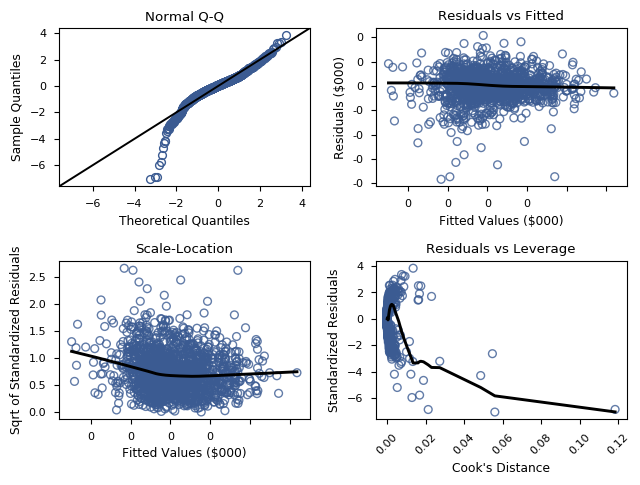

In [18]:
# Fit model and compare to other two
fits['Model 4'], regr_m4 = lin_reg_sm(train_process1, m3_vars, 'SalePrice_log')
fit_stats_df(fits)

Shows better fit to linear regression assumptions but fit statistics are not comparable because of the transformation. RMSE is comparable showing an improvement in fit.

In [19]:
print("Model 3 RMSE = {:,.2f}".format(rmse_metric(regr_m3, False)))
print("Model 4 RMSE = {:,.2f}".format(rmse_metric(regr_m4, True)))

Model 3 RMSE = 25,979.61
Model 4 RMSE = 24,134.84


## Model 5 - Transformed Predictors

Skewness and lack of a linear relationship result in the need to log-transform and/or "floor" variables.

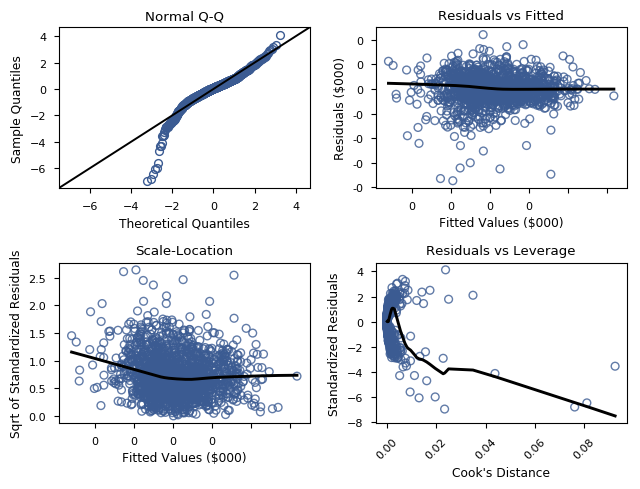

In [20]:
# Transform continuous variables
train_process1['BsmtFSF_flr_log'] = np.where(train_process1['BsmtFSF'] > 600, 
                                             np.log1p(train_process1['BsmtFSF']), 
                                             np.log1p(600))
test_process1['BsmtFSF_flr_log'] = np.where(test_process1['BsmtFSF'] > 600, 
                                            np.log1p(test_process1['BsmtFSF']), 
                                            np.log1p(600))

train_process1['GarageArea_flr_log'] = np.where(train_process1['GarageArea'] > 250, 
                                                np.log1p(train_process1['GarageArea']), 
                                                np.log1p(250))
test_process1['GarageArea_flr_log'] = np.where(test_process1['GarageArea'] > 250, 
                                               np.log1p(test_process1['GarageArea']), 
                                               np.log1p(250))

train_process1['OutdoorSF_flr_log'] = np.where(train_process1['OutdoorSF'] > 200, 
                                               np.log1p(train_process1['OutdoorSF']), 
                                               np.log1p(200))
test_process1['OutdoorSF_flr_log'] = np.where(test_process1['OutdoorSF'] > 200, 
                                              np.log1p(test_process1['OutdoorSF']), 
                                              np.log1p(200))

train_process1['LotArea_cap_log'] = np.log1p(train_process1['LotArea_cap'])
test_process1['LotArea_cap_log'] = np.log1p(test_process1['LotArea_cap'])

train_process1['GarageArea_0'] = np.where(train_process1['GarageArea'] > 0, 0, 1)
test_process1['GarageArea_0'] = np.where(test_process1['GarageArea'] > 0, 0, 1)

train_process1['BsmtFSF_0'] = np.where(train_process1['BsmtFSF'] > 0, 0, 1)
test_process1['BsmtFSF_0'] = np.where(test_process1['BsmtFSF'] > 0, 0, 1)


m5_vars = ['Neighborhood_cluster', 'OverallQual_grp', 'HomeAge_flr', 
           'BsmtUnfSF', 'LotArea_cap_log', 'GrLivArea', 'OutdoorSF_flr_log',
           'GarageArea_flr_log', 'BsmtFSF_flr_log', 'GarageArea_0', 'BsmtFSF_0']

fits['Model 5'], regr_m5 = lin_reg_sm(train_process1, 
                                      m5_vars, 
                                      'SalePrice_log')
fit_stats_df(fits)

Similar diagnostics to Model 4 with slightly better fit.

In [21]:
print("Model 3 RMSE = {:,.2f}".format(rmse_metric(regr_m3, False)))
print("Model 4 RMSE = {:,.2f}".format(rmse_metric(regr_m4, True)))
print("Model 5 RMSE = {:,.2f}".format(rmse_metric(regr_m5, True)))

Model 3 RMSE = 25,979.61
Model 4 RMSE = 24,134.84
Model 5 RMSE = 23,810.17


## Analyze Model 5 VIF

Display table of VIFs showing that multicolinearity is not a significant concern for this model.

In [22]:
X_sub = train_process1[m5_vars].copy()
X_dum = sm.add_constant(one_hot_encode(X_sub, X_sub))
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_dum.values, i) for i in range(X_dum.shape[1])]
vif["Feature"] = X_dum.columns
vif.at[0, 'Feature'] = "Intercept"
vif.set_index(['Feature']).round(2)

VIF
Feature                        
Intercept               2016.52
HomeAge_flr                3.49
BsmtUnfSF                  2.05
LotArea_cap_log            1.42
GrLivArea                  2.14
OutdoorSF_flr_log          1.21
GarageArea_flr_log         2.19
BsmtFSF_flr_log            2.00
GarageArea_0               1.21
BsmtFSF_0                  1.64
Neighborhood_cluster_1     2.58
Neighborhood_cluster_2     2.31
OverallQual_grp_grp_02     1.05
OverallQual_grp_grp_03     1.11
OverallQual_grp_grp_04     1.23
OverallQual_grp_grp_06     1.57
OverallQual_grp_grp_07     2.37
OverallQual_grp_grp_08     2.80
OverallQual_grp_grp_09     1.92
OverallQual_grp_grp_10     1.41

Correlation matrix of continuous variables show lack of concern of multicolinearity.

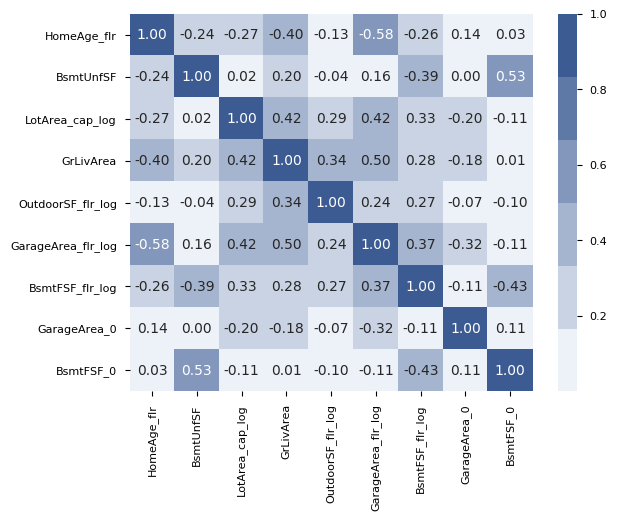

In [23]:
intVars_m5 = ['HomeAge_flr', 'BsmtUnfSF', 
              'LotArea_cap_log', 'GrLivArea', 
              'OutdoorSF_flr_log', 'GarageArea_flr_log', 
              'BsmtFSF_flr_log', 'GarageArea_0', 
              'BsmtFSF_0']
corr = train_process1[intVars_m5].corr()
abs_corr = np.absolute(corr)
ax = sns.heatmap(abs_corr, annot=corr, fmt=".02f",
                 cmap=sns.light_palette(sns.xkcd_rgb["denim blue"]),
                 xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

## Create Additional Categorical Features

Create groupings to reduce cardinality in categorical features. There are quite a few variables to assess but for under 100 terms, a data scientist should be expected to understand all of them. 

Variables that lack a strong relationship are not included in the final list of categorical variables used in feature selection.

In [24]:
# Only those that added value in models 3-5
currentVars = ['HomeAge_flr', 'BsmtUnfSF', 
               'LotArea_cap_log', 'GrLivArea', 
               'OutdoorSF_flr_log', 'GarageArea_flr_log', 
               'BsmtFSF_flr_log', 'GarageArea_0', 
               'BsmtFSF_0', 'Neighborhood_cluster', 
               'OverallQual_grp', 'SalePrice_log', 
               'SalePrice']

# Add indicators
nomVars.extend(['LowQualFin_ind', 'SecondFlr_ind'])

In [25]:
# Group Alley to get gravel alley indicator
def grp_A(row):
    if row['Alley'] == "Gr":
        return 1
    else:
        return 0
# Group BedroomAbvGr
def grp_BAG(row):
    if row['BedroomAbvGr'] <= 2:
        return "A. 0-2"
    elif row['BedroomAbvGr'] == 3:
        return "B. 3"
    else:
        return "C. 4+"
# Group BsmtCond
def grp_BC(row):
    if row['BsmtCond'] in ["Po", "Fa"]:
        return "B. Po and Fa"
    elif row['BsmtCond'] in ["Ex", "Gd"]:
        return "D. Gd and Ex"
    elif row['BsmtCond'] in ["Blank"]:
        return "A. None"
    else:
        return "C. TA"
# Group BsmtExposure
def grp_BE(row):
    if row['BsmtExposure'] in ["Mn", "Av"]:
        return "C. Mn and Av"
    elif row['BsmtExposure'] in ["Gd"]:
        return "D. Gd"
    elif row['BsmtExposure'] in ["Blank"]:
        return "A. No Bsmt"
    else:
        return "B. No"
# BsmtFinType1 - already grouped
# BsmtFinType2 - already grouped
# Bathrooms in basement are grouped
def grp_B(row):
    if (row['BsmtHalfBath']*0.5 + row['BsmtFullBath']) >= 2:
        return "C. 2+"
    elif (row['BsmtHalfBath']*0.5 + row['BsmtFullBath']) >= 1:
        return "B. 1 to 1.5"
    else:
        return "A. 0 to 0.5"
# Group BsmtQual
def grp_BQ(row):
    if row['BsmtQual'] in ["Blank", "Po", "Fa"]:
        return "A. Po Fa no Bsmt"
    elif row['BsmtQual'] in ["Ex"]:
        return "C. Ex"
    else:
        return "B. TA Gd"
# Create CentralAir indicator
def grp_CA(row):
    if row['CentralAir'] == "Y":
        return 1
    else:
        return 0
# Condition 1
def grp_C1(row):
    if row['Condition1'] in ["PosA", "PosN"]:
        return "Pos"
    elif row['Condition1'] in ["RRNe", "RRAe"]:
        return "RRe"
    elif row['Condition1'] in ["RRNn", "RRAn"]:
        return "RRn"
    else:
        return row['Condition1']
# Condition 2
def grp_C2(row):
    if row['Condition2'] in ["PosA", "PosN"]:
        return "Pos"
    elif row['Condition2'] in ["RRNe", "RRAe"]:
        return "RRe"
    elif row['Condition2'] in ["RRNn", "RRAn"]:
        return "RRn"
    else:
        return row['Condition2']
# Group Electrical to create fuse indicator
def grp_EL(row):
    if row['Electrical'] in ["FuseA", "FuseF", "FuseF"]:
        return 1
    else:
        return 0
# ExterCond already grouped
# ExterQual already grouped
# Exterior1 will create clusters
# Exterior2 will create clusters
# Fence already grouped
# FireplacesQu already grouped
# Fireplaces
def grp_FP(row):
    if row['Fireplaces'] >= 2:
        return "C. 2+"
    elif row['Fireplaces'] == 1:
        return "B. 1"
    else:
        return "A. 0"
# Foundation
def grp_FO(row):
    if row['Foundation'] in ["Stone", "Wood"]:
        return "Stone-Wood"
    else:
        return row['Foundation']
# FullBath - group half and full together
def grp_FB(row):
    if (row['HalfBath']*0.5 + row['FullBath']) >= 2.5:
        return "D. 2.5+"
    if (row['HalfBath']*0.5 + row['FullBath']) >= 2:
        return "C. 2"
    elif (row['HalfBath']*0.5 + row['FullBath']) > 1:
        return "B. 1.5"
    else:
        return "A. 0 to 1"
# Functional
def grp_FC(row):
    if row['Functional'] in ["Sal"]:
        return 1
    else:
        return 0
# Group garage cars
def grp_GC(row):
    if row['GarageCars'] >= 3:
        return "grp_03"
    elif row['GarageCars'] == 3:
        return "grp_02"
    else:
        return "grp_" + str(int(row['GarageCars'])).zfill(2)
# Drop GarageCond
# GarageFinish already grouped
# Drop GarageQual 
# GarageType already grouped
# HalfBath - grouped with full
# Drop Heating - few obs in other levels
# HeatingQC already grouped
# HouseStyle
def grp_HS(row):
    if row['HouseStyle'] in ["2.5Fin", "2Story"]:
        return "2Story and 2.5Fin"
    elif row['HouseStyle'] in ["2.5Unf", "1Story"]:
        return "1Story and 2.5Unf"
    else:
        return row['HouseStyle']
# Drop KitchenAbvGr - Few obs over 1
# Group KitchenQual 
def grp_KQ(row):
    row['KitchenQual'] = str(row['KitchenQual']).strip()
    if row['KitchenQual'] in ["Ex"]:
        return "D. Ex"
    elif row['KitchenQual'] in ["Gd"]:
        return "C. Gd"
    else:
        return "A. TA Fa Po"
# LandContour already grouped
def grp_LCO(row):
    if row['LandContour'] in ["Lvl", "Low", "Bnk"]:
        return "Lvl Low Bnk"
    else:
        return row['LandContour']
# Drop LandSlope - a lot of variance in response
# LotConfig
def grp_LC(row):
    if row['LotConfig'] in ["FR2", "FR3"]:
        return "FR2-3"
    else:
        return row['LotConfig']
# LotShape
def grp_LS(row):
    if row['LotShape'] in ["IR1", "IR2", "IR3"]:
        return 1
    else:
        return 0
# Group MasVnrType
def grp_MVT(row):
    if row['MasVnrType'] in ["BrkFace"]:
        return "B. BrkFace"
    elif row['MasVnrType'] in ["Stone"]:
        return "C. Stone"
    else:
        return "A. Other"
# Group MiscFeature to be a shed indicator
def grp_MF(row):
    if row['MiscFeature'] == "Shed":
        return 1
    else:
        return 0
# Drop MoSold relationship does not seem predictive
# Group Neighborhood - already clustered
# OverallCond
def grp_OC(row):
    if row['OverallCond'] <= 3:
        return "grp_03"
    else:
        return "grp_" + str(row['OverallCond']).zfill(2) 
# Group OverallQual - already grouped
# PavedDrive already grouped
# Drop PoolQC
# Drop RoofMat
# Group RoofStyle
def grp_RS(row):
    if row['RoofStyle'] == "Hip":
        return 1
    else:
        return 0
# Group SaleCondition
def grp_SC(row):
    if row['SaleCondition'] in ["Abnorml", "AdjLand"]:
        return "Ab Adj"
    else:
        return row['SaleCondition']
# Group SaleType
def grp_STY(row):
    if row['SaleType'] in ["COD", "Con", "Oth", "CWD"]:
        return "A. Other"
    elif row['SaleType'] in ["New"]:
        return "C. New"
    else:
        return "B. WD"     
# Group Street
def grp_ST(row):
    if row['Street'] == "Grvl":
        return 1
    else:
        return 0
# Drop SubClass - other variables cover in less complex way  
# Drop utilities - only two obs not in most common level
# Group YrSold - before and after crisis
def grp_YS(row):
    if row['YrSold'] > 2007:
        return 1
    else:
        return 0
# Group Zoning
def grp_Z(row):
    if row['Zoning'] in ["C", "I", "A", "RH"]:
        return "A. Other"
    elif row['Zoning'] in ["RM"]:
        return "B. RM"
    elif row['Zoning'] in ["FV"]:
        return "D. FV"
    else:
        return "C. RL"    
# LowQualFin_ind already grouped
# SecondFlr_ind already grouped

def grp_categories(df):
    grpd = df.copy()
    grpd['Alley_Gr'] = grpd.apply(grp_A, axis=1)
    grpd['Bath_grp'] = grpd.apply(grp_FB, axis=1)
    grpd['BedroomAbvGr_grp'] = grpd.apply(grp_BAG, axis=1)
    grpd['BsmtCond_grp'] = grpd.apply(grp_BC, axis=1)
    grpd['BsmtExposure_grp'] = grpd.apply(grp_BE, axis=1)
    grpd['BsmtBath_grp'] = grpd.apply(grp_B, axis=1)
    grpd['BsmtQual_grp'] = grpd.apply(grp_BQ, axis=1)
    grpd['CentralAir_grp'] = grpd.apply(grp_CA, axis=1)
    grpd['Condition1_grp'] = grpd.apply(grp_C1, axis=1)
    grpd['Condition2_grp'] = grpd.apply(grp_C2, axis=1)
    grpd['Electrical_fuse'] = grpd.apply(grp_EL, axis=1)
    grpd['Fireplaces_grp'] = grpd.apply(grp_FP, axis=1)
    grpd['Foundation_grp'] = grpd.apply(grp_FO, axis=1)
    grpd['Functional_Sal'] = grpd.apply(grp_FC, axis=1)
    grpd['GarageCars_grp'] = grpd.apply(grp_GC, axis=1)
    grpd['HouseStyle_grp'] = grpd.apply(grp_HS, axis=1)
    grpd['KitchenQual_grp'] = grpd.apply(grp_KQ, axis=1)
    grpd['LandContour_grp'] = grpd.apply(grp_LCO, axis=1)
    grpd['LotConfig_grp'] = grpd.apply(grp_LC, axis=1)
    grpd['LotShape_IR'] = grpd.apply(grp_LS, axis=1)
    grpd['MasVnrType_grp'] = grpd.apply(grp_MVT, axis=1)
    grpd['MiscFeature_Shed'] = grpd.apply(grp_MF, axis=1)
    grpd['OverallCond_grp'] = grpd.apply(grp_OC, axis=1)
    grpd['RoofStyle_Hip'] = grpd.apply(grp_RS, axis=1)
    grpd['SaleCondition_grp'] = grpd.apply(grp_SC, axis=1)
    grpd['SaleType_grp'] = grpd.apply(grp_STY, axis=1)
    grpd['Street_Grvl'] = grpd.apply(grp_ST, axis=1)
    grpd['YrSold_Crisis'] = grpd.apply(grp_YS, axis=1)
    grpd['Zoning_grp'] = grpd.apply(grp_Z, axis=1)
    return grpd

train_process2 = grp_categories(train_process1)
test_process2 = grp_categories(test_process1)

nomVars_final = ['Alley_Gr', 'BedroomAbvGr_grp', 'BsmtCond_grp', 
                 'BsmtBath_grp', 'BsmtExposure_grp', 'BsmtQual_grp', 
                 'CentralAir_grp', 'Electrical_fuse', 
                 'KitchenQual_grp', 'MasVnrType_grp', 
                 'MiscFeature_Shed',
                 'PavedDrive', 'SaleType_grp', 'Street_Grvl', 
                 'YrSold_Crisis', 'Zoning_grp', 'LowQualFin_ind',
                 'SecondFlr_ind', 'RoofStyle_Hip', 'OverallCond_grp',
                 'LotShape_IR', 'LotConfig_grp', 'LandContour_grp',
                 'SaleCondition_grp', 'BsmtFinType1', 'BsmtFinType2',
                 'Condition1_grp', 'Bath_grp',
                 'HeatingQC', 'HouseStyle_grp', 'GarageFinish',
                 'Functional_Sal', 'Foundation_grp', 'FireplaceQu',
                 'Fireplaces_grp', 'Fence', 'GarageType', 'ExterQual']

Exterior variables clustered in similar way to Neighborhood.

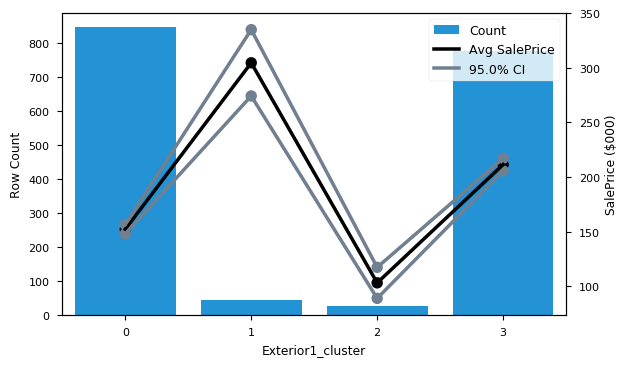

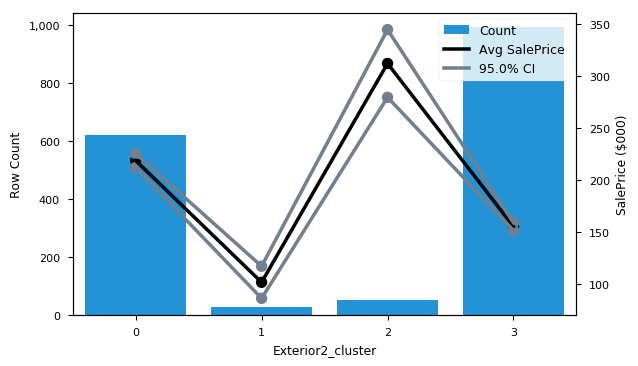

In [26]:
# Calculate mean price per sqft
ex1 = train_process2[['Exterior1', 'SalePrice']].groupby('Exterior1').agg([np.mean])
ex2 = train_process2[['Exterior2', 'SalePrice']].groupby('Exterior2').agg([np.mean])
ex1.columns = ex1.columns.droplevel()
ex2.columns = ex2.columns.droplevel()
ex1.columns = ['SalePrice']
ex2.columns = ['SalePrice']

# Cluster exterior into 3 clusters by avg price per sq as a string
kmeans1 = KMeans(n_clusters=4, random_state=11).fit(ex1[['SalePrice']].values)
kmeans2 = KMeans(n_clusters=4, random_state=19).fit(ex2[['SalePrice']].values)
ex1['Exterior1_cluster'] = kmeans1.predict(ex1[['SalePrice']].values)
ex2['Exterior2_cluster'] = kmeans2.predict(ex2[['SalePrice']].values)

# Drop cluster variable if it already exists in training data
try:
    train_process2.drop(['Exterior1_cluster'], axis=1, inplace=True)
    train_process2.drop(['Exterior2_cluster'], axis=1, inplace=True)
except:
    pass

# Merge with training data
train_process2 = train_process2.reset_index().merge(ex1[['Exterior1_cluster']].reset_index(),
                                      on=['Exterior1'], how='left')
train_process2 = train_process2.reset_index().merge(ex2[['Exterior2_cluster']].reset_index(),
                                      on=['Exterior2'], how='left')
train_process2.set_index(['index'], inplace=True)

# Convert to string to use as categorical
train_process2['Exterior1_cluster'] = train_process2['Exterior1_cluster'].astype(str)
train_process2['Exterior2_cluster'] = train_process2['Exterior2_cluster'].astype(str)

# Plot relationship (cluster numbers will not be in order)
category_plot(train_process2, var = 'Exterior1_cluster', alpha=0.05)
category_plot(train_process2, var = 'Exterior2_cluster', alpha=0.05)

In [27]:
# Drop cluster variable if it already exists in training data
try:
    test_process2.drop(['Exterior1_cluster'], axis=1, inplace=True)
    test_process2.drop(['Exterior2_cluster'], axis=1, inplace=True)
except:
    pass

# Merge with training data
test_process2 = test_process2.reset_index().merge(ex1[['Exterior1_cluster']].reset_index(),
                                      on=['Exterior1'], how='left')
test_process2 = test_process2.reset_index().merge(ex2[['Exterior2_cluster']].reset_index(),
                                      on=['Exterior2'], how='left')
test_process2.set_index(['index'], inplace=True)

# Convert to string to use as categorical
test_process2['Exterior1_cluster'] = test_process2['Exterior1_cluster'].astype(str)
test_process2['Exterior2_cluster'] = test_process2['Exterior2_cluster'].astype(str)

In [28]:
nomVars_final.extend(['Exterior1_cluster', 'Exterior2_cluster'])

In [29]:
nomVars_final.sort()

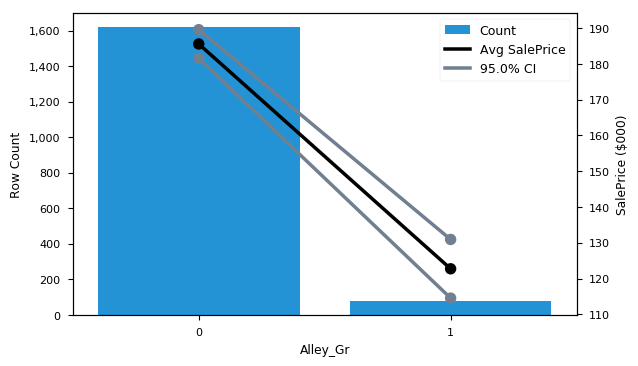

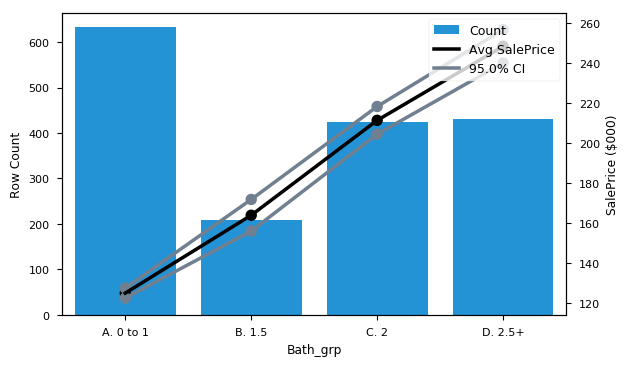

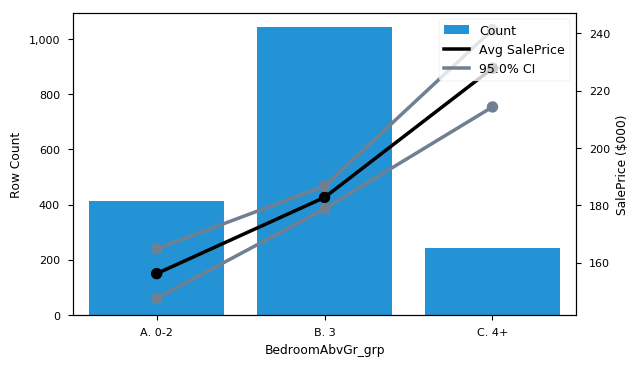

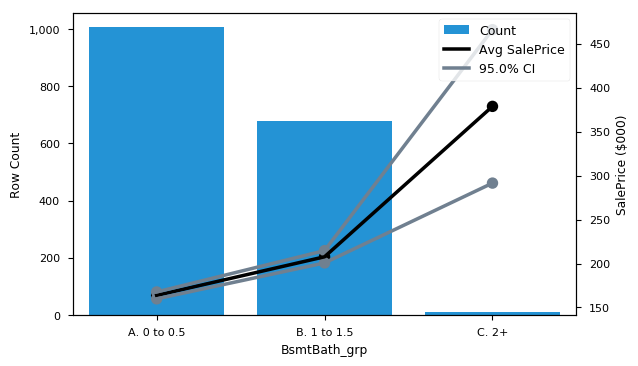

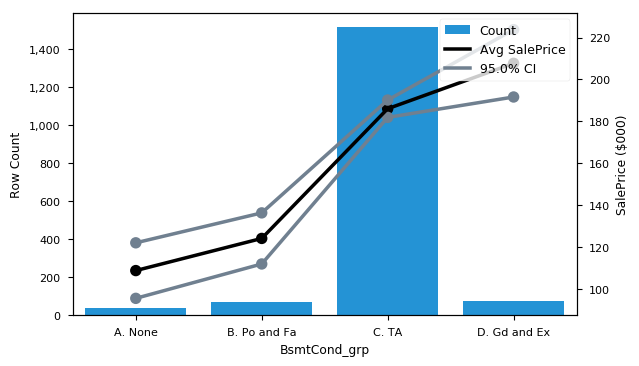

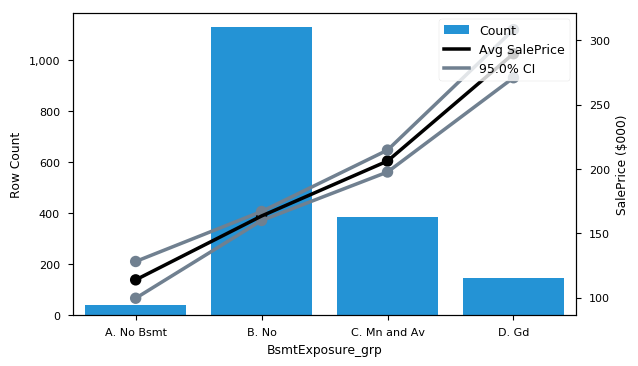

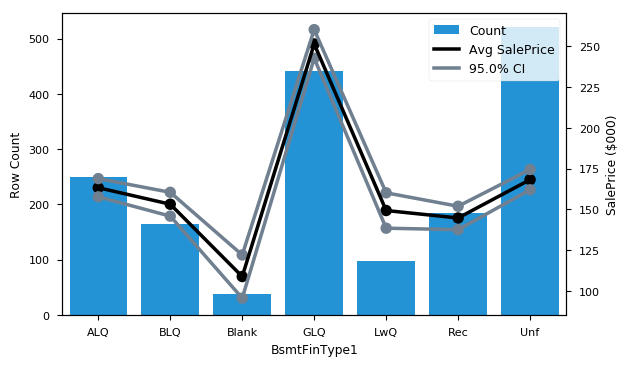

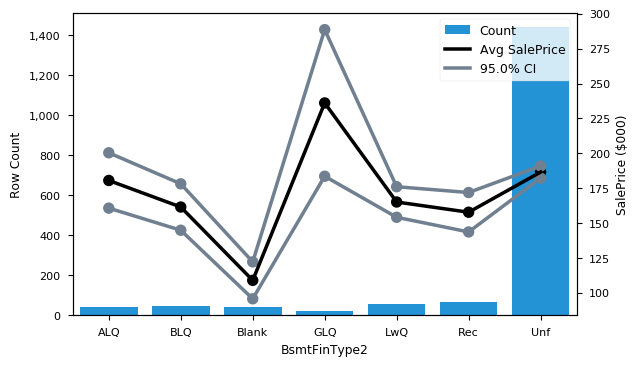

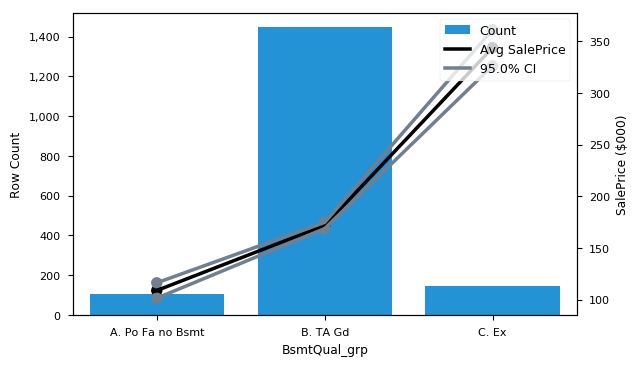

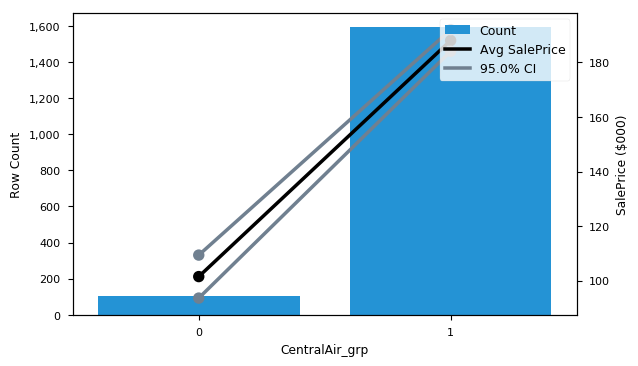

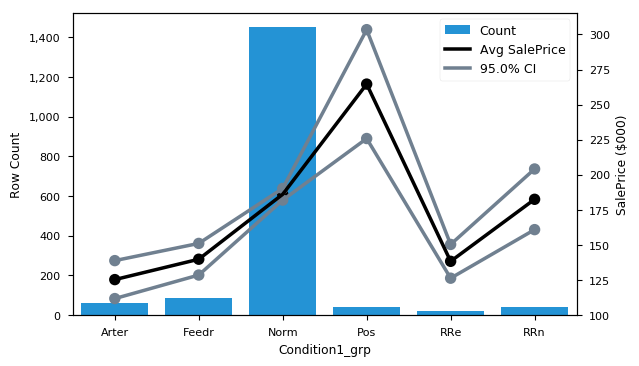

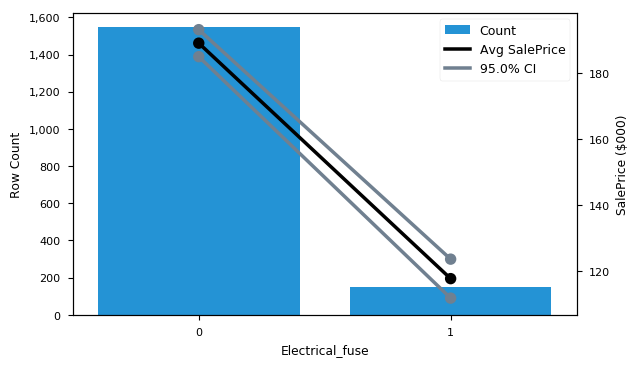

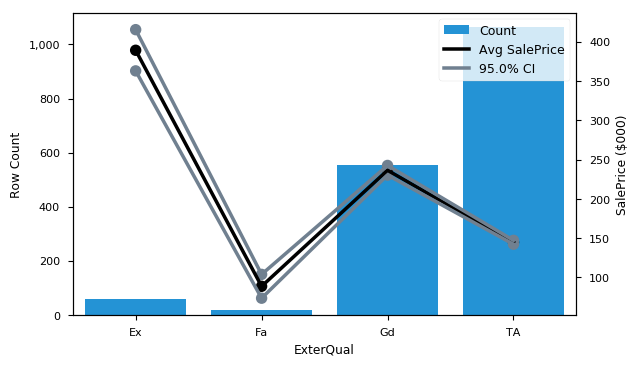

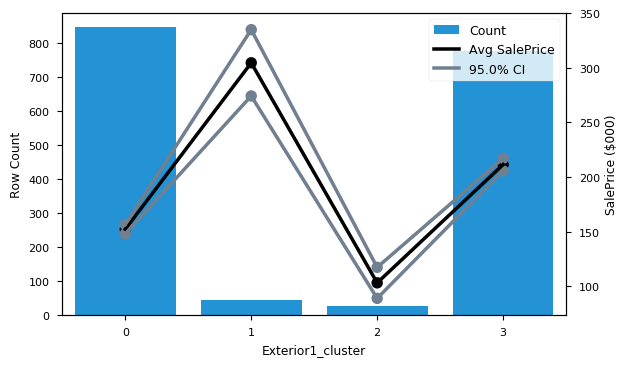

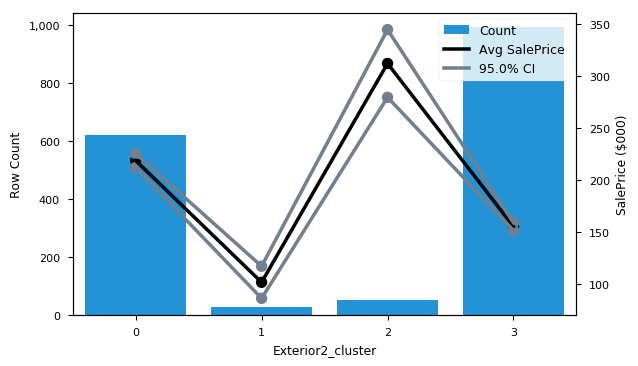

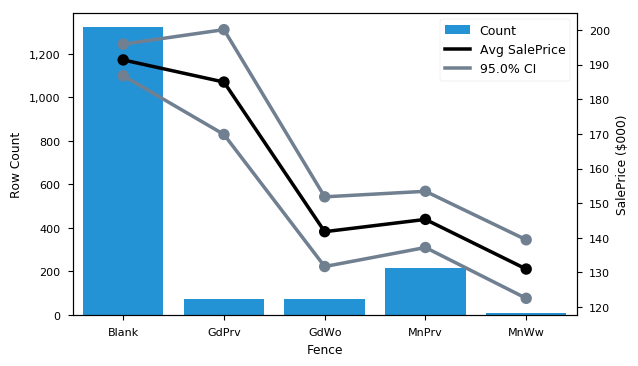

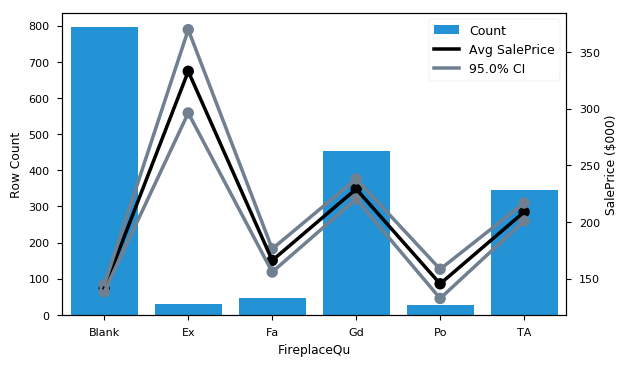

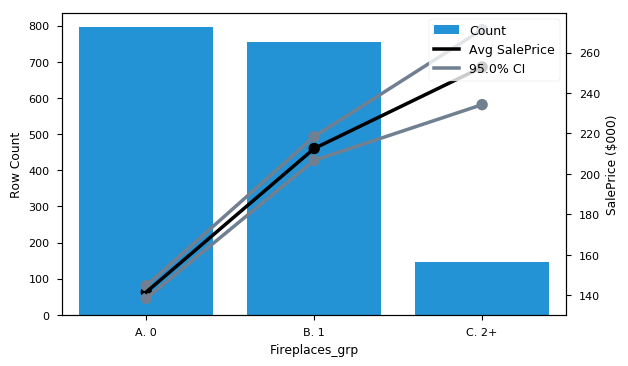

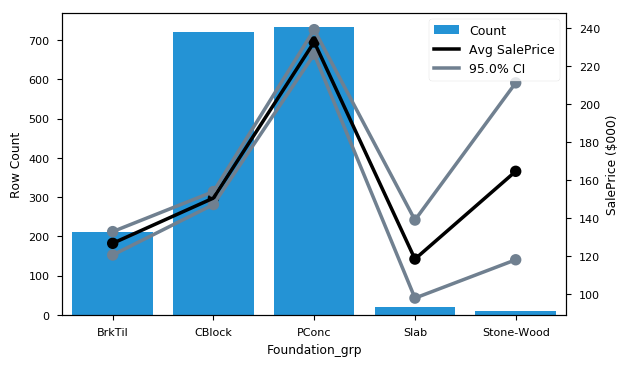

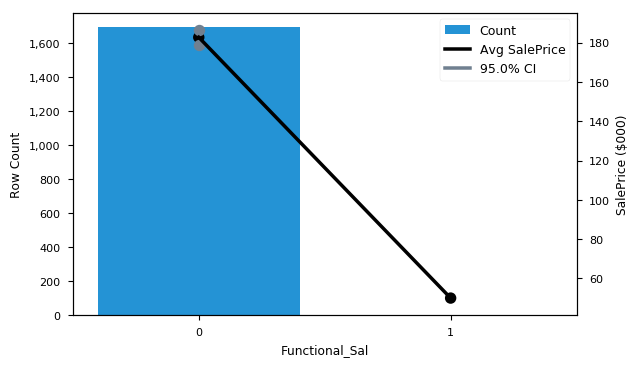

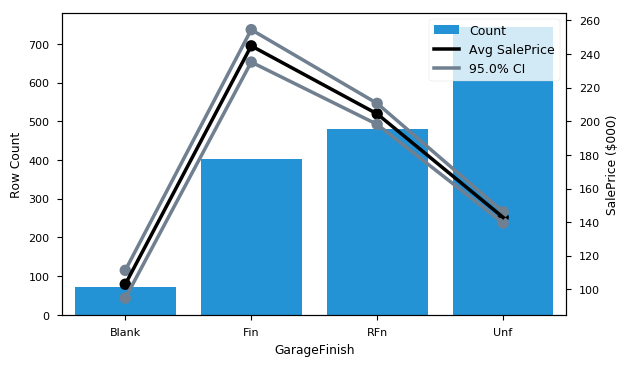

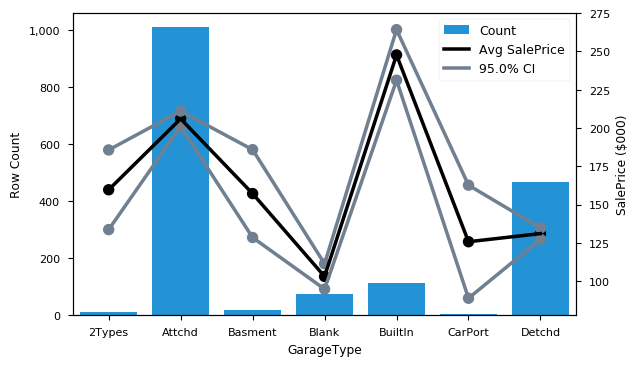

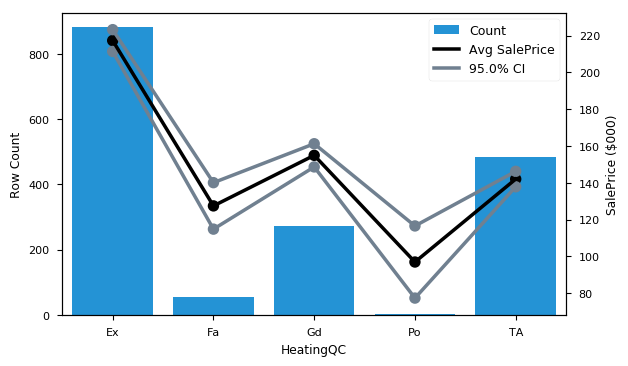

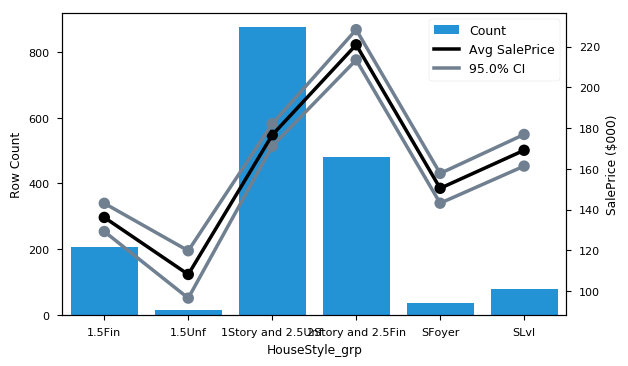

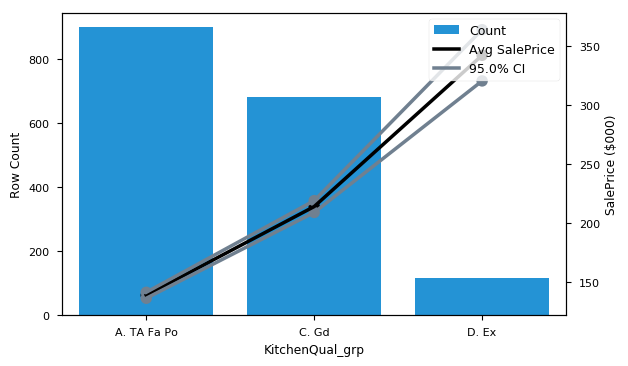

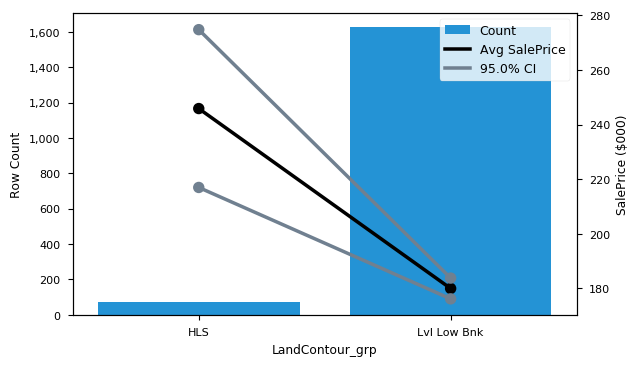

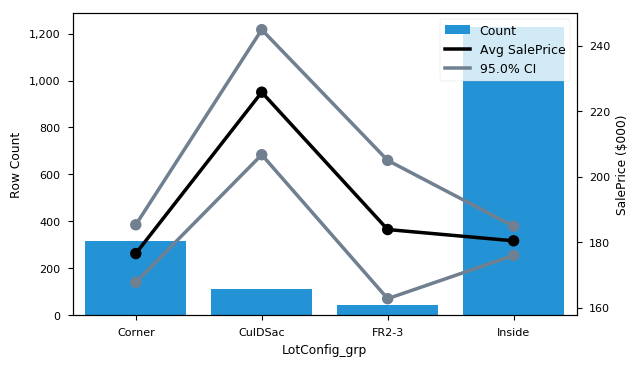

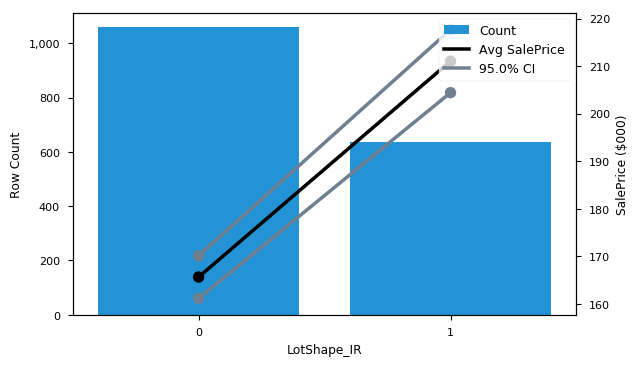

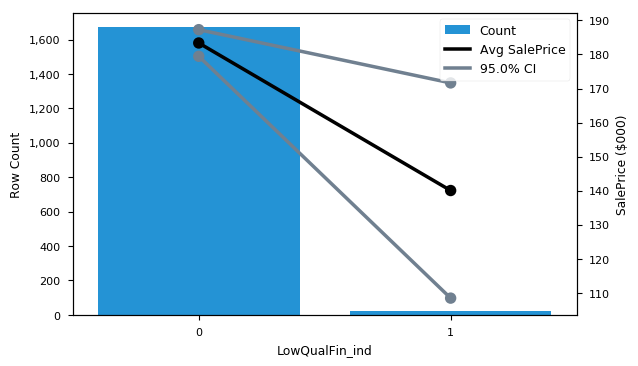

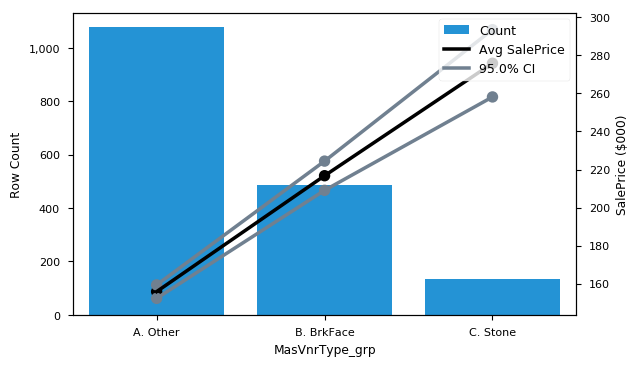

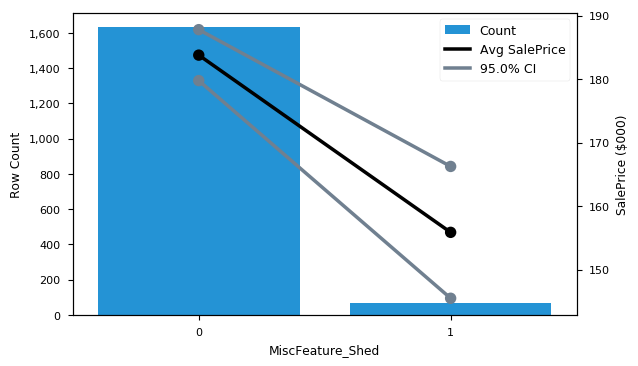

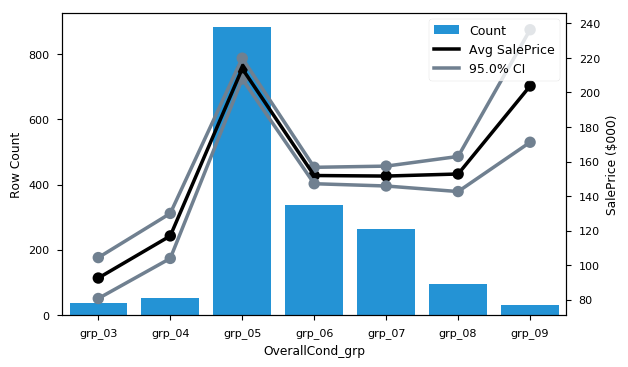

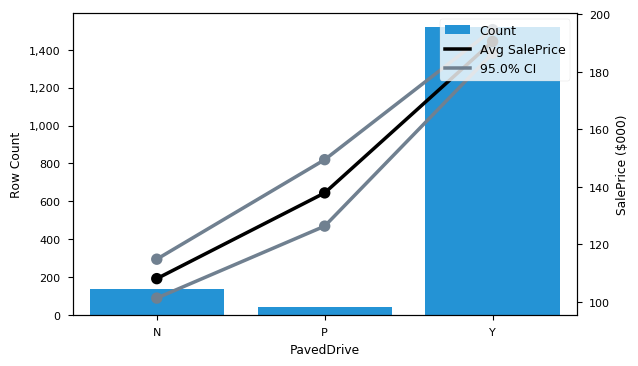

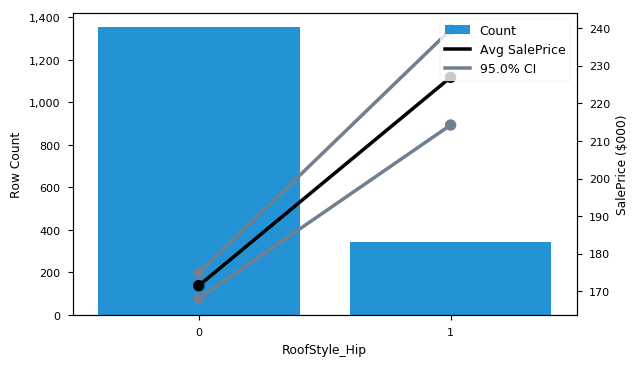

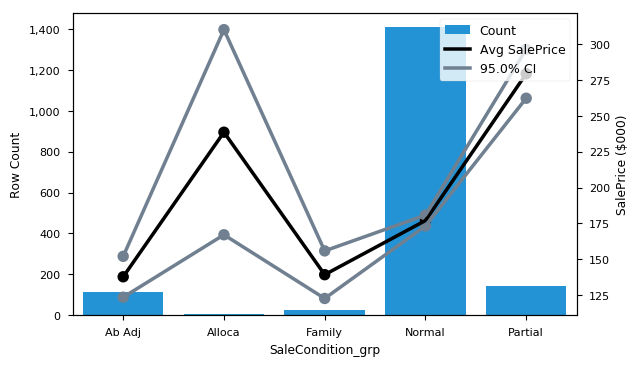

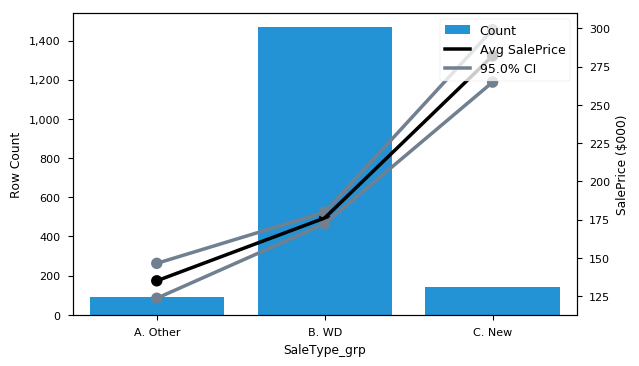

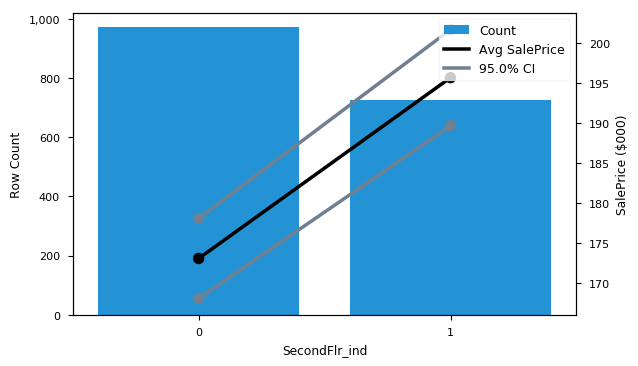

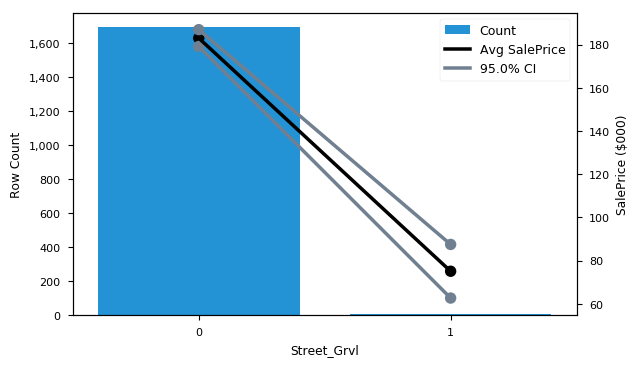

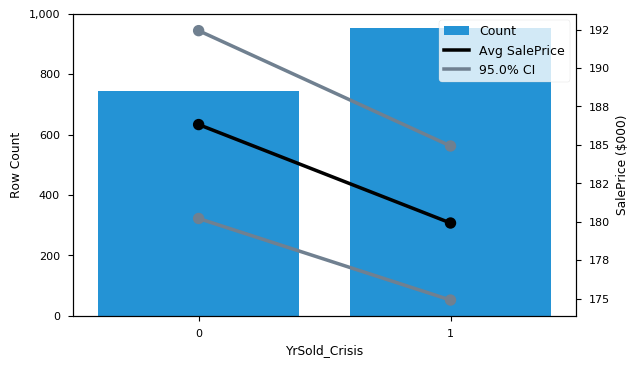

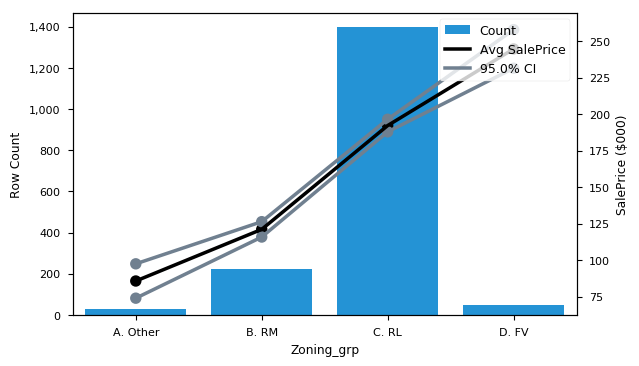

In [30]:
# Plot one way relationships for all final categorical variables considered
for var in nomVars_final:
    category_plot(train_process2, var=var, alpha=0.05)

In [31]:
# Combine lists of predictors
all_predictors = nomVars_final + currentVars

## Model 6 - F Regression

Use automated variable selection to select 10 best features to use in the model. This process requires dummy variables to be created prior to running. 

In [32]:
# F_regression with top ten predictors
selector = SelectKBest(score_func=f_regression, k = 10)

# Create dummy variables
y = train_process2[['SalePrice_log']].copy()
X_sub = train_process2[all_predictors[:-2]].copy()
X_dum = one_hot_encode(X_sub, X_sub)

fit = selector.fit(X_dum,y.values.ravel())

# Print variables used
cols_used = selector.get_support(indices=True)
cols_df = X_dum[cols_used]
final = cols_df.columns.tolist()
final

['HomeAge_flr',
 'LotArea_cap_log',
 'GrLivArea',
 'GarageArea_flr_log',
 'BsmtFSF_flr_log',
 'Bath_grp_D. 2.5+',
 'BsmtFinType1_GLQ',
 'BsmtQual_grp_C. Ex',
 'ExterQual_Gd',
 'Neighborhood_cluster_1']

Fit model with those top 10 predictors

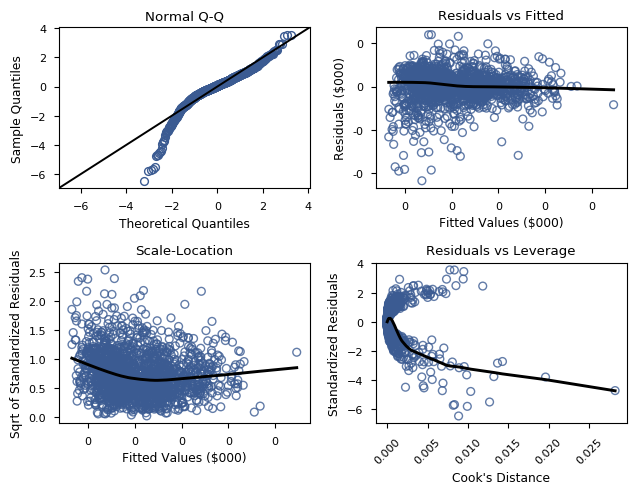

In [33]:
# Note that dummied is set to true since selecting dummied predictors already
fits['Model 6'], regr_m6 = lin_reg_sm(train_process2, 
                                      final, 
                                      'SalePrice_log',
                                      dummied=True)
fit_stats_df(fits)

In [34]:
print("Model 3 RMSE = {:,.2f}".format(rmse_metric(regr_m3, False)))
print("Model 4 RMSE = {:,.2f}".format(rmse_metric(regr_m4, True)))
print("Model 5 RMSE = {:,.2f}".format(rmse_metric(regr_m5, True)))
print("Model 6 RMSE = {:,.2f}".format(rmse_metric(regr_m6, True)))

Model 3 RMSE = 25,979.61
Model 4 RMSE = 24,134.84
Model 5 RMSE = 23,810.17
Model 6 RMSE = 28,996.25


Model 6 shows poor performance by all statistics.

## Bonus  Cross-Validation Train Test Split

Fitting Model 5 to a subset and scoring on another subset shows that the model generalizes well.

In [35]:
np.random.seed(3)
train_bonus, test_bonus = train_test_split(train_process2, test_size = 0.3)
# Fit the best model so far (Model 5) using training and score on test
y = train_bonus[['SalePrice_log']].copy()
X_sub = train_bonus[m5_vars].copy()
X_dum = sm.add_constant(one_hot_encode(X_sub, X_sub))
regr = sm.OLS(y.values, X_dum).fit()

# Score model on test split
test_sub = test_bonus[m5_vars].copy()
test_dum = sm.add_constant(one_hot_encode(test_sub, X_sub))
prediction = np.exp(regr.predict(test_dum))

# Check fit stats on test split
rsquared, rsquared_adj, rmse = metrics(test_bonus['SalePrice'].values,
                                       prediction, 
                                       len(test_dum.columns))
print("R-Squared = {:.3f}; Adj R-Squared = {:.3f}; RMSE = {:.3f};".format(rsquared, rsquared_adj, rmse))

R-Squared = 0.915; Adj R-Squared = 0.911; RMSE = 24180.052;


## Bonus Model 7 - Cross-Validation with Forwards Selection

F regression feature selection does not result in a good fit in this case. Instead, I use a script to minimize the RMSE of out-of-fold predictions using cross-validation. In this sense it is forward selection based on a validation performance. This mimics the behavior of the GLMSELECT procedure in SAS.

In [36]:
# Set my random seed to replicate results
np.random.seed(2)

# Create a list of predictors to loop through
all_predictors = nomVars_final + currentVars

# Remove targets from list
try:
    all_predictors.remove('SalePrice')
    all_predictors.remove('SalePrice_log')
except:
    pass

final_predictors = []
rmse_prog = []
y = train_process2.SalePrice_log

# Start at a very high RMSE and improve from there
rmse_best = 1000000

# Possibly have as many steps as there are variables
for i in range(1, len(all_predictors)+1):
    # Loop through all remaining predictors for a step
    for var in all_predictors:
        model_data = train_process2[final_predictors + [var]].copy()
        # Get cross validation metrics for a specific variable in a step
        m, rmse = model_stepc(model_data, y, i, var)
        # Track the best performing
        if rmse < rmse_best:
            rmse_best = rmse
            m_best = m
            var_best = var
        else:
            pass
    # After the inner loop, remove the best variable and add to final list
    try:
        all_predictors.remove(var_best)
        final_predictors += [var_best]
        rmse_prog += [rmse_best]
    # If no variable improved the fit, stop the outer loop
    except:
        break
    # Print steps
    print(m_best)

Model 1; Var: OverallQual_grp; R-Squared = 0.734; Adj R-Squared = 0.733; RMSE = 42111.184;
Model 2; Var: GrLivArea; R-Squared = 0.818; Adj R-Squared = 0.817; RMSE = 34838.516;
Model 3; Var: BsmtFSF_flr_log; R-Squared = 0.860; Adj R-Squared = 0.859; RMSE = 30608.043;
Model 4; Var: HomeAge_flr; R-Squared = 0.878; Adj R-Squared = 0.877; RMSE = 28518.770;
Model 5; Var: OverallCond_grp; R-Squared = 0.887; Adj R-Squared = 0.886; RMSE = 27470.294;
Model 6; Var: SecondFlr_ind; R-Squared = 0.893; Adj R-Squared = 0.892; RMSE = 26745.540;
Model 7; Var: Neighborhood_cluster; R-Squared = 0.898; Adj R-Squared = 0.897; RMSE = 26060.393;
Model 8; Var: BsmtExposure_grp; R-Squared = 0.902; Adj R-Squared = 0.901; RMSE = 25506.735;
Model 9; Var: Fireplaces_grp; R-Squared = 0.906; Adj R-Squared = 0.904; RMSE = 25096.137;
Model 10; Var: LotArea_cap_log; R-Squared = 0.908; Adj R-Squared = 0.907; RMSE = 24762.556;
Model 11; Var: SaleCondition_grp; R-Squared = 0.910; Adj R-Squared = 0.909; RMSE = 24449.137;
Mo

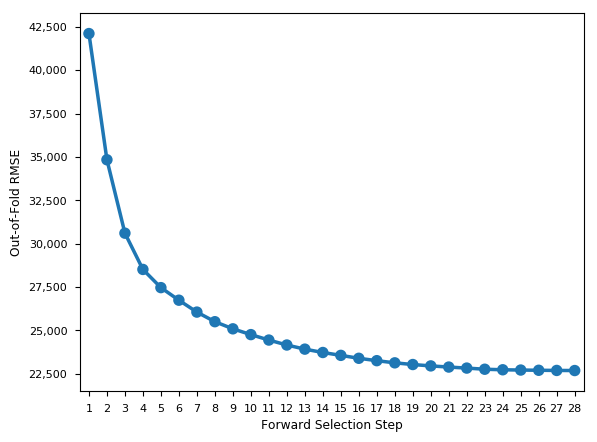

In [37]:
# Plot how the RMSE decreases through the selection
steps = list(range(1,29))
ax = sns.pointplot(x=steps, y=rmse_prog)
yticks = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x) for x in yticks])
ax.set(ylabel="Out-of-Fold RMSE", xlabel="Forward Selection Step")
plt.show()

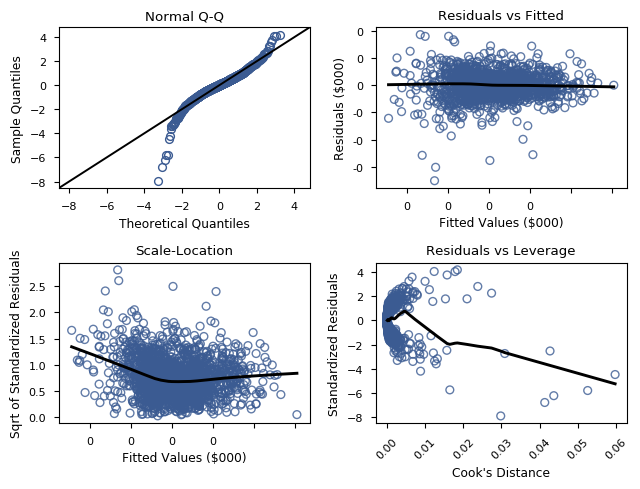

In [38]:
# RMSE seems to level off around the 18th step
m7_vars = final_predictors[0:18]
fits['Model 7'], regr_m7 = lin_reg_sm(train_process2, 
                                      m7_vars, 
                                      'SalePrice_log')
fit_stats_df(fits)

In [39]:
print("Model 3 RMSE = {:,.2f}".format(rmse_metric(regr_m3, False)))
print("Model 4 RMSE = {:,.2f}".format(rmse_metric(regr_m4, True)))
print("Model 5 RMSE = {:,.2f}".format(rmse_metric(regr_m5, True)))
print("Model 6 RMSE = {:,.2f}".format(rmse_metric(regr_m6, True)))
print("Model 7 RMSE = {:,.2f}".format(rmse_metric(regr_m7, True)))

Model 3 RMSE = 25,979.61
Model 4 RMSE = 24,134.84
Model 5 RMSE = 23,810.17
Model 6 RMSE = 28,996.25
Model 7 RMSE = 19,729.31


Diagnostics still show heavy tails but performance is improved greatly. 

All of coefficients have intuitive relationships with sale price except for the minimum and average basmenet exposure. The coefficient is small, so impact should be minimal. 

## Sumbit Model 7 to Kaggle

In [40]:
test_sub = test_process2[m7_vars]
train_sub = train_process2[m7_vars]
test_dum = sm.add_constant(one_hot_encode(test_sub, train_sub))
predictions = pd.DataFrame(np.exp(regr_m7.predict(test_dum)))

# Output in format needed for Kaggle
predictions.columns = ['p_saleprice']
predictions.to_csv('model7_alan_kessler.csv')

The result from Kaggle was is approximately 50% worse than assignment 1. Given that Model 7 was specified on cross-validation out-of-fold predictions, the test scores should not have a RMSE much different than the RMSE from step 17 in the forwards selection. Given that RMSE will be heavily influenced by outliers and the residuals of Model 7 have heavy tails, it is worth analyzing the residuals more closely. 

In [41]:
# Add residual to training set
train_process2['Resid'] = train_process2['SalePrice'] - np.exp(regr_m7.fittedvalues)
# Output to csv to view in Excel
train_process2.to_csv('train_resid_check.csv')

After sorting by the absolute value of the residuals, I observe that the top six largest errors are partial sales which indicates that the home was not finished when last assessed. From the boxplot, this generates errors in both directions. 

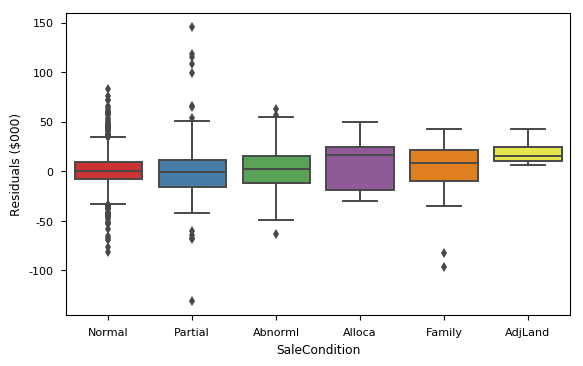

In [42]:
# Plot residuals by SaleCondition
plt.figure(figsize=(6.5, 4))
ax = sns.boxplot(x='SaleCondition', y='Resid', data=train_process2, palette = "Set1")
ticks = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
ax.set(ylabel='Residuals ($000)')
plt.show()

Looking at the outliers more closely, there appears to be a trend that the largest outliers are partial sales where the home was built close to when it was sold but that the home was remodeled after being sold. This could indicate that the home was sold without being finished but with outliers in both directions, it is impossible to know which is the case with the information given.

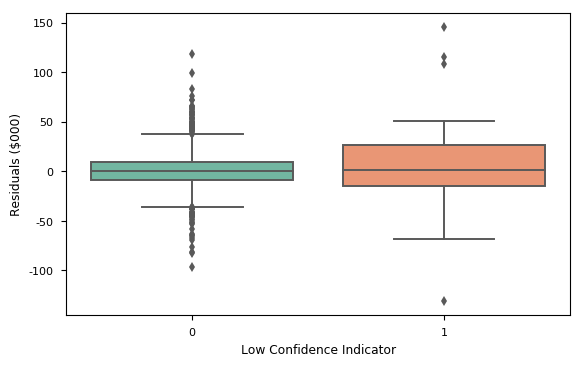

In [43]:
# Check approximate difference in year sold and year built (assuming all homes are build at midpoint of year)
train_process2['Diff'] = train_process2['YrSold'] + train_process2['MoSold']/12 - (train_process2['YearBuilt']+0.5)
# Create a low confidence indicator when home is built within a year of selling,
# it is a partial sale, and it was remodeled after being built
train_process2['lc_ind'] = np.where((train_process2['Diff'] <= 1) 
                                    & (train_process2['SaleCondition'] == "Partial") 
                                    & (train_process2['YearRemodel'] > train_process2['YearBuilt']) , 
                                    1, 0)

# Box plot of residuals low confidence indicator
plt.figure(figsize=(6.5, 4))
ax = sns.boxplot(x='lc_ind', y='Resid', data=train_process2, palette = "Set2")
ticks = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(x/1000) for x in ticks])
ax.set(ylabel='Residuals ($000)', xlabel='Low Confidence Indicator')
plt.show()

In [44]:
lc_cnt = np.sum(train_process2['lc_ind'])
print("{} training observations with low confidence".format(lc_cnt))

35 training observations with low confidence


## Model 8 - Simple Model for Low Confidence Values

The Kaggle performance dropped when moving from a simple to complex model. This indicates that the assumption of equal variance for least squares regression is violated. There is a defined population with more uncertain results. Either a Bayesian approach could be considered or a more simple model could be applied to the population with less certainty to avoid overfitting. This latter approach is similar to what is done in credit modeling when an individual does not have a full credit history.

This model is fit to the entire training data but controls for sale condition. In the simple model, the sale price is based entirely on the lot area and neighborhood because the property characteristics cannot be relied on. 

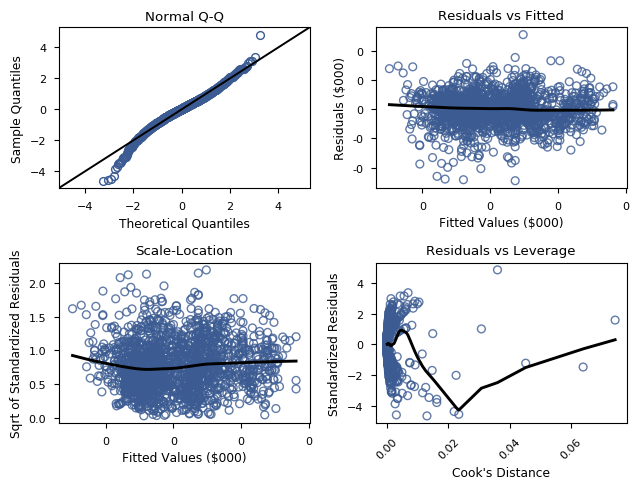

In [45]:
m8_vars = ['Neighborhood_cluster', 
           'LotArea_cap_log', 
           'SaleCondition_grp']

fits['Model 8'], regr_m8 = lin_reg_sm(train_process2, 
                                      m8_vars, 
                                      'SalePrice_log',
                                      dummied=False)
fit_stats_df(fits)

In [46]:
print("Model 8 RMSE = {:,.2f}".format(rmse_metric(regr_m8, True)))

Model 8 RMSE = 53,409.18


## Score Combination of Models 

Use Model 8 for low confidence and Model 7 otherwise.

First for training data.

In [47]:
# Score model 7 on training set
train_sub = train_process2[m7_vars]
train_dum7 = sm.add_constant(one_hot_encode(train_sub, train_sub))
train_process2['model7'] = np.exp(regr_m7.predict(train_dum7))

# Score model 8 on training set
train_sub = train_process2[m8_vars]
train_dum8 = sm.add_constant(one_hot_encode(train_sub, train_sub))
train_process2['model8'] = np.exp(regr_m8.predict(train_dum8))

# Determine low confidence observations
train_process2['Diff'] = train_process2['YrSold'] + train_process2['MoSold']/12 - (train_process2['YearBuilt']+0.5)
train_process2['lc_ind'] = np.where((train_process2['Diff'] <= 1) 
                                   & (train_process2['SaleCondition'] == "Partial") 
                                   & (train_process2['YearRemodel'] > train_process2['YearBuilt']), 
                                   1, 0)

# Choose which to model to use based on the indicator
train_process2['p_saleprice'] = np.where(train_process2['lc_ind'] == 1,
                                         train_process2['model8'],
                                         train_process2['model7'])

rsquared, rsquared_adj, rmse = metrics(train_process2['SalePrice'], 
                                       train_process2['p_saleprice'],
                                       len(train_dum7.columns)+len(train_dum8.columns))

print("R-Squared = {:.3f}; Adj R-Squared = {:.3f}; RMSE = {:.3f};".format(rsquared, rsquared_adj, rmse))

R-Squared = 0.918; Adj R-Squared = 0.915; RMSE = 23395.625;


In [48]:
# Score model 7 on test set
test_sub = test_process2[m7_vars]
train_sub = train_process2[m7_vars]
test_dum = sm.add_constant(one_hot_encode(test_sub, train_sub))
predictions = pd.DataFrame(np.exp(regr_m7.predict(test_dum)))
predictions.columns = ['model7']

# Score model 8 on test set
test_sub = test_process2[m8_vars]
train_sub = train_process2[m8_vars]
test_dum = sm.add_constant(one_hot_encode(test_sub, train_sub))
predictions['model8'] = np.exp(regr_m8.predict(test_dum))

# Determine low confidence observations
test_process2['Diff'] = test_process2['YrSold'] + test_process2['MoSold']/12 - (test_process2['YearBuilt']+0.5)
test_process2['lc_ind'] = np.where((test_process2['Diff'] <= 1) 
                                   & (test_process2['SaleCondition'] == "Partial") 
                                   & (test_process2['YearRemodel'] > test_process2['YearBuilt']) , 
                                   1, 0)

# Choose which to model to use based on the indicator
predictions['p_saleprice'] = np.where(test_process2['lc_ind'] == 1, 
                                      predictions['model8'],
                                      predictions['model7'])

# Output final predictions
predictions[['p_saleprice']].to_csv('assignment2_alan_kessler.csv')

Print Neighborhood cluster assignments for final model formula

In [49]:
sqft.reset_index().sort_values(by=['Neighborhood_cluster', 'Neighborhood']).set_index(['Neighborhood'])

Avg Actual Price per SF  Avg Predicted Price per SF  \
Neighborhood                                                        
BrkSide                     88.653210                   98.655057   
ClearCr                     85.557711                   77.410791   
Edwards                     83.658217                   88.311200   
IDOTRR                      79.658569                   96.869361   
Mitchel                     85.801194                   80.456556   
NAmes                       82.413392                   81.481753   
NWAmes                      82.996141                   83.931433   
OldTown                     85.893530                  102.168330   
SWISU                       77.707044                   92.970999   
Sawyer                      83.857690                   79.923166   
Veenker                     84.524098                   83.881836   
Blmngtn                    141.147876                  142.793122   
NridgHt                    127.054716                  120.972656   
Somerst                    123.757451                  121.112915   
StoneBr                    124.694044                  112.097603   
CollgCr                    103.232639                  101.025973   
Crawfor                     95.725418                   92.854773   
Gilbert                    105.128743                  105.310797   
NoRidge                     98.638210                   94.806403   
SawyerW                     94.613572                   97.314508   
Timber                     107.314500                  104.408669   

              Neighborhood_cluster  
Neighborhood                        
BrkSide                          0  
ClearCr                          0  
Edwards                          0  
IDOTRR                           0  
Mitchel                          0  
NAmes                            0  
NWAmes                           0  
OldTown                          0  
SWISU                            0  
Sawyer                           0  
Veenker                          0  
Blmngtn                          1  
NridgHt                          1  
Somerst                          1  
StoneBr                          1  
CollgCr                          2  
Crawfor                          2  
Gilbert                          2  
NoRidge                          2  
SawyerW                          2  
Timber                           2